<h1><center> Neural network based sounding of the atmosphere (BOA) </center></h1>
<h2><center> Available data: Dataset of radiosonde profiles of T and q </center></h2>

<h3><center> Author: Davide Savini (0310795) </center></h3>
<h2><center> University of Rome Tor Vergata </center></h2>

## Preparation: libraries installation

First of all, it has to be opened an anaconda prompt and do the follows:

<code>conda config --append channels conda-forge</code> to add *conda-forge channel* for the installation of **h5netcdf package**.

It has to be created and activated successfully the enviroment **tf** with related packages in the following way:
<p style="background:black">
<code style="background:black;color:white">
    C:\Users\Davide>conda create -n tf tensorflow pandas scikit-learn matplotlib basemap xarray netCDF4 h5netcdf h5py numpy matplotlib basemap
    C:\Users\Davide>conda activate tf
    (tf) C:\Users\Davide>jupyter notebook
</code>
</p>

Checked the **wget** package, which was found already inside the environment; to be sure it can be installed with the following command:
<p style="background:black">
<code style="background:black;color:white">
    (tf) C:\Users\Davide>pip install wget
    Requirement already satisfied: wget in c:\users\davide\anaconda3\envs\tf\lib\site-packages (3.2)
</code>
</p>

The **seaborn package** is also installed:
<p style="background:black">
<code style="background:black;color:white">
    (tf) C:\Users\Davide>conda install seaborn
</code>
</p>

and the installation of **pyOptimalEstimation** and **numba** libraries with <code>pip install pyOptimalEstimation</code> and <code>pip install numba</code> on same previous conda prompt.


## 1st point
Starting from the radiosonde dataset of lab06 create a dataset to be used as **input for a radiative transfer code**. Pay attention to the selection of the profiles, **eliminating all profiles with missing data**.

### Preliminary steps: import of the necessary package

In [1]:
import sys
import traceback
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pn
import xarray as xr
import scipy.stats as stats

import pyOptimalEstimation as pyOE

%matplotlib inline
sns.set(style='ticks', palette='deep')

# print("done")

Some helper routines and the radiative transfer model are put in the `lib` folder which can be loaded with

In [2]:
sys.path.append('lib')
import nonScatMWRadTran
import supporting_routines

# print("done")

### Load prior dataset from Lab06
Start with loading the previously prepared (see [lib/prepare_radiosondes.ipynb](lib/prepare_radiosondes.ipynb)) collection of radiosonde profiles at NSA from 04/2002 to 02/2020. It's used the xarray library which provides a transparent interface to netCDF files so that it can be directly copied the required variables form the netCDF file. The unit of **temperature (temp)** is **Kelvin**, **specific humidity (q)** is provided in **g/kg**, **pressure (bar_pres)** is in **Pa**, and **height** in **meter**.

In [3]:
prior = xr.open_dataset('data/radiosonde_climatology_nsa_2002-2020.nc')
prior
# print(prior)

<xarray.Dataset>
Dimensions:   (time: 24095, height: 60)
Coordinates:
  * time      (time) datetime64[ns] 2002-04-29 ... 2020-02-04T18:00:00
  * height    (height) float32 8.0 108.0 208.0 ... 1.901e+04 2.001e+04 2.251e+04
Data variables:
    temp      (time, height) float32 ...
    q         (time, height) float32 ...
    bar_pres  (time, height) float32 ...

It's removed from dataset the overall **missing data**, and it's anticipated the third point of the project i.e. the removing from dataset the same few profiles used for test in lab06.

In [4]:
# Removing from the dataset the same few profiles used for test in lab06 on the third point of the project.
profileTT = np.array([
    '2004-03-16T12:00:00.000000000', '2006-04-01T00:00:00.000000000',
    '2009-01-30T18:00:00.000000000', '2014-07-27T06:00:00.000000000',
    '2018-01-08T12:00:00.000000000'
],dtype='datetime64[ns]')

# from prior dataset i select time values correlated with profileTT to eliminate missing data
profiles_1 = prior.sel(time=profileTT) # storage of 5 profiles on 24090 profiles
prior = prior.drop_sel(time=profileTT) # update of the dataset
nLev = len(prior.height) # length of height that are 60 heights
print("Prior dataset is cleaned from same few profiles used for test in lab06!")

# I want to use all profiles inside dataset excluding profiles with missing data.
profiles = prior.time
db_clean = prior.dropna('time', how='any')
print("Prior dataset is cleaned from missing datas!")
db_clean

# print(len(db_clean.temp))
# print(len(db_clean.q))
# print(len(db_clean.bar_pres))

Prior dataset is cleaned from same few profiles used for test in lab06!
Prior dataset is cleaned from missing datas!


<xarray.Dataset>
Dimensions:   (time: 12857, height: 60)
Coordinates:
  * time      (time) datetime64[ns] 2002-04-29T18:00:00 ... 2020-02-04T18:00:00
  * height    (height) float32 8.0 108.0 208.0 ... 1.901e+04 2.001e+04 2.251e+04
Data variables:
    temp      (time, height) float32 258.0 257.0 257.4 ... 225.8 228.4 227.6
    q         (time, height) float32 0.888 0.8949 0.9468 ... 0.007162 0.009497
    bar_pres  (time, height) float32 1.02e+05 1.007e+05 ... 5.1e+03 3.51e+03

## 2nd point
Using the code in lab02 calculate the clear sky radiative transfer for all profiles of the dataset in 1. Pay particular attention to the unit of measurements of the variables in the dataset and required by the RT code. Apply a radiative transfer for the observer at the bottom of the atmosphere for the channel list described in lab06. Add to the simulated TBs a gaussian noise with null mean value and a std equal to the one used for the error covariance matrix in lab06.


### Clear Sky Radiative Transfer (Theory Recap) 

In the microwave region (1–300 GHz), water vapor has two significant rotational absorption lines at 22.235 GHz and 183.31 GHz. There are, however, numerous other lines at frequencies just above this region that also contribute to the microwave absorption spectrum. The closest is at 325.15 GHz. Figure 1.1 displays the spectrum of $k_{H2O}$, $k_{O2}$ and $k_g$ at sea level over the frequency range from 1 to 300 GHz.

<figure>
<img src="images/ka_absorption_coeff.png" alt="Absorption spectra of oxygen, water vapor, and their sum at sea level." />
<center><figcaption>Fig 1.1: Absorption spectra of oxygen, water vapor, and their sum at sea level.</figcaption></center>
</figure>

For the purposes of upward-looking and downward-looking microwave remote sensing, gaseous absorption coefficient $k_g$ is simply the sum of $k_{O2} + k_{H2O}$. For zenith angles up to 70°, and in some cases up to 85°, the atmosphere may be considered to be horizontally stratified, but for spaceborne systems, spherical geometries are needed at such large angles. Nevertheless, it will be adopted the horizontal stratification model because of its simplicity, in which case the oblique optical thickness of a layer with uniform properties extending between heights $z_1$ and $z_2$ is

\begin{equation}
\tau(z_1,z_2) = \tau_0(z_1,z_2)sec\theta,
\end{equation}

where $\theta$ defines the direction of propagation relative to the zenith and $\tau_0(z_1,z_2)$ is the zenith optical thickness (Figure 1.2), defined in terms of the absorption coefficient $k_a(z)$ as

\begin{equation}
\tau_0(z_1,z_2) = \int^{z_2}_{z_1}k_a(z)dz.
\end{equation}

<figure>
<img src="images/optical_depth.png" alt="optical depth" />
<center><figcaption>Fig 1.2: For a horizontally stratified atmosphere, the optical thickness $\tau(z_1,z_2)$ for propagation along angle $\theta$ is related to the zenith optical thickness $\tau_0(z_1,z_2)$ by $sec\theta$.</figcaption></center>
</figure>

The units of $\tau_0$ are nepers (Np) or dB, depending on whether the absorption coefficient $k_a$ is expressed in
nepers per unit length or dB per unit length, respectively. Under clear-sky conditions, $k_a = k_g$, where $k_g$ is the
gaseous absorption coefficient. If $(z_1, z_2) =(0,\infty)$, which encompasses the entire atmosphere, $\tau_0(0,\infty)$ is then called the zenith opacity $\tau_0$ (Figure 1.3).

<figure>
<img src="images/zenith_opacity.png" alt="zenith_opacity" />
<center><figcaption>Fig 1.3: Zenith opacity of the atmosphere for three water-vapor conditions.</figcaption></center>
</figure>

 So it can be defined for our case the optical depth as follows:
 
\begin{equation}
\tau_0(0,z)= \int^{z}_{0}k_a(f,z')dz' \quad [Np].
\end{equation}

The oblique transmissivity of the stratified atmosphere is related to the zenith opacity by 

\begin{equation}\Upsilon(0,\infty)=e^{-\tau_0(0,\infty)sec(\theta)}=[\Upsilon_0(0,\infty)]^{sec(\theta)}\end{equation}

where

\begin{equation} \Upsilon_0(0,\infty) = e^{-\tau_0(0,\infty)}\end{equation}

is the zenith transmissivity. Figure 1.4 displays the microwave spectrum of $\Upsilon_0(0,\infty)$ for three different atmospheres, characterized by different surface temperatures $T_0$ and total integrated water-vapor contents that is defined as total mass of water vapor contained in a vertical column of unit cross section:

\begin{equation} M_v=\int^{\infty}_{0}\rho_v(z)dz=\rho_0H_4\end{equation} 

where $\rho_0 = 7.72 g/m^3$, and $H_4 = 2 km$, $M_v = 15.44 kg/m^2$ or $1.54 g/cm^2$.

In the window bands, the dry polar atmosphere is far more transparent than the humid atmosphere of the tropics.

<figure>
<img src="images/zenith_transmissivity_tropical_vs_polar_vs_standard.png" alt="zenith_transmissivity_tropical_vs_polar_vs_standard" />
<center><figcaption>Fig 1.4: Atmosphere transmissivity as characterized by different surface temperatures $T_0$ and integrated water-vapor content $M_v$.</figcaption></center>
</figure>

The downward emission by the atmosphere (excluding cosmic background radiation) is denoted $T_{DN}(f.\theta)$ and is

\begin{equation}T_{DN}(f, \theta)= sec\theta \int^{\infty}_{0}k_a(f,z) T(z) e^{-\tau_0(0,z)sec(\theta)}dz\end{equation} 

where $T(z)$ is the thermometric temperature of the atmosphere at height $z$. In the absence of clouds and rain, $k_a=k_g$, the gaseous absorption coefficient. Figure (1.5) presents plots of $T_{DN}$ for $ \theta = 0$ (zenith-looking) for the same model atmosphere and conditions that pertain to Fig. 1.3. 

<figure>
<img src="images/downward_brightness_temperature.png" alt="downward_brightness_temperature" />
<center><figcaption>Fig 1.5: Zenith brightness temperature of the atmosphere $T_{DN}$ for $0$, $5$, and $10 g/m^3$ surface water vapor ($2.1 km$ scale height) computed using the Standard Atmosphere model with surface temperature 290 K.</figcaption></center>
</figure>

As expected, the high attenuation levels at and around the resonant frequencies of the oxygen absorption lines at 60 and 118 GHz cause $T_{DN}$ to “saturate” at a value only slightly lower than the surface temperature of 290 K. The same is true for the 183 and 323 GHz water-vapor absorption lines (except for $\rho = 0$).

<figure>
<img src="images/radiative_transfer.png" alt="The radiometric temperature measured by an upward-looking radiometer includes contributions from our galaxy." />
<center><figcaption>Fig 1.6: The radiometric temperature measured by an upward-looking radiometer includes contributions from our galaxy.</figcaption></center>
</figure>

In addition to the downwelling radiation represented by $T_{DN}$, an upward-looking radiometer receives a relatively small amount of energy due to cosmic and galactic radiation incident upon the atmosphere from the top (Fig. 1.6). Thus, the apparent temperature of the sky (bottom of Atmosphere brightness temperature in clear sky condition), usually referred to as the sky radiometric temperature, $T_{SKY}$, consists of:

\begin{equation}T_{SKY}(f, \theta) = T_{EXTRA}\Upsilon(0,\infty) + T_{DN}.\end{equation}

and

\begin{equation}T_{EXTRA}=T_{COS} + T_{GAL} + T_{SUN}\end{equation}

where $T_{COS}$, $T_{GAL}$ and $T_{SUN}$ are the cosmic, galactic and sun brightness temperatures, respectively, whose sum it can be called the extraterrestrial brightness temperature, $T_{EXTRA}$.

#### Parameter summary

- Cosmic background radiation temperature $T_{COS} = 2.7 \quad [K]$
- Radiation from the galaxy is approximated  to  0 -> $T_{GAL} = 0 \quad [K]$
- Radiation from Sun  approximated  to  0 -> $T_{SUN} = 0 \quad [K]$
- Absorption Coefficient $k_a \quad [m^{-1}]$
- Zenith angle $\theta \quad [deg]$
- Optical Depth (total zenith atmospheric opacity) $\tau_0 \quad nepers[Np]$ or $[dB]$.


###  Weighting Functions and radiative transfer in Clear sky from Lab02
### Creation of some usefull functions

In [5]:
def calc_tau0(ka,Z,i0,i1):
    #calculates the nadir optical depth integrating ka*dZ between two levels i0 and i1
    # ka absroption coefficient in Np/m
    # Z height in m
    # i0,i1 the two extreme levels for integration
    if i0<=i1:
        tau0=np.trapz(ka[i0:i1],Z[i0:i1])
    else:
        tau0=np.trapz(ka[i1:i0],Z[i1:i0])
    return tau0
def calc_gamma(ka,Z,i0,i1,UMU):
    #calculates the trasmissivity
    # ka absroption coefficient in Np/m
    # Z height in m
    # i0,i1 the two levels for integration
    # UMU is cosine of the observation angle
    tau0=calc_tau0(ka,Z,i0,i1)
    gamma=np.exp(-1*tau0/UMU)
    return gamma

def calc_weighting_function(ka,Z,i,UMU,updir):
    #calculates the trasmissivity
    # ka absroption coefficient in Np/m
    # Z height in m
    # i the level of the weighting function
    # UMU is cosine of the observation angle
    # updir indicates if the weighting function
    #       is for radiaiton moving upward (updir=1)
    #       or downward (updir=0)
    if updir==1:
        gamma=calc_gamma(ka,Z,i,len(Z),UMU)
    else:
        gamma=calc_gamma(ka,Z,i,0,UMU)
    wf=ka[i]*gamma/UMU
    return wf
def calc_TB_DN(ka,Z,T,UMU):
    # calculates the brightness temperaure emitted by the atmosphere and directed downward
    # ka absroption coefficient in Np/m
    # Z height in m
    # T is the temperature in K
    # UMU is cosine of the observation angle
    
    wf=np.zeros(np.shape(Z))
    for i in range(0,len(Z)):
        wf[i]=calc_weighting_function(ka,Z,i,UMU,updir=0)
    T_DN=np.trapz(wf*T,Z)
    return T_DN

def calc_TB_UP(ka,Z,T,UMU):
    # calculates the brightness temperaure emitted by the atmosphere and directed upward
    # ka absroption coefficient in Np/m
    # Z height in m
    # T is the temperature in K
    # UMU is cosine of the observation angle
    wf=np.zeros(np.shape(Z))
    for i in range(0,len(Z)):
        wf[i]=calc_weighting_function(ka,Z,i,UMU,updir=1)
    T_UP=np.trapz(wf*T,Z)
    return T_UP

def plot_WF(wf1,Z):
    import matplotlib.pyplot as plt
    n=np.shape(wf1)[1]
    
    color = iter(plt.cm.rainbow(np.linspace(0, 1, n)))   
    for iv in range(n):
        col=next(color)
        plt.plot(wf1[:,iv]*1000, Z/1000,c=col,label = "ch "+str(iv+1))
    plt.ylim(0,22)
    plt.legend()    
    
    plt.xlabel('Weighting Functions 1/km')
    plt.ylabel('Height km')
    plt.show()


### Computation of Brightness temperature for each profile of Prior Dataset

The used frequencies are the standard one in GHz of an HATPRO microwave radiometer (Rose et al 2005) (ref. lab06). 
The Output from last command are the Height (in km), Pressure (in Pa), Temperature (in K) and relative humidity (in % from 0 to 100) (ref. lab02).
Units must be:
- heights in [m],
- temperature in [K],
- pressure in [Pa],
- absolute humidity in [kgm^-3] (ref. lab6), 
- relative humidity in % from 0 to 100 (ref. lab2),
- specific humidity in g/kg and than in log10 (ref. lab6), 
- zenith angle of observation in deg.
- frequency vector in GHz.   

Three primary measurements of humidity are widely employed: 

- **Absolute humidity** is expressed as either mass of water vapor per volume of moist air (in grams per cubic meter **[gm^-3]**) or as mass of water vapor per mass of dry air (usually in grams per kilogram **[g/kg]**). Absolute humidity is the amount of water vapour present in a given mass of air at a particular time and temperature. Absolute humidity can be representated in any units of mass.

- **Relative humidity**, often expressed as a **percentage**, indicates a present state of absolute humidity relative to a maximum humidity given the same temperature. Relative humidity is the ratio of the amount of water vapour present in the atmosphere to the maximum amount of water vapour the air can hold.

- **Specific humidity** is the ratio of water vapor mass to total moist air parcel mass. From prior dataset is named **q** and expressed in **[g/kg]**.


The humidity is extracted from dataset that is stored like a specific humidity. The function <code>relative_humidity_from_specific_humidity</code> it's imported from the library <code>metpy</code> to computate the relative humidity (units in %) from the specific one. Needed import of <code>load_atm_prf.py</code> and <code>gas_attenuation_rose98.py</code> for the computation of TB. In the next cell it is shown three examples of extrapolated profiles from dataset computating Brightness Temperature, Weighting Function and plots of the two.

<!-- The computation of overall Brightness temperatures (TB) respect each profile requires a lot of computational time.
With the used hardware:
- CPU model: Intel(R) Core(TM) i5-5200U CPU @ 2.20GHz
  Thread count: 2 physical cores, 4 logical processors;
- RAM=8GB and SSD=512GB;

I met a freezing problem of the loop, so I computed the TBs using Colab (computation time = 3/4 hours) and saved in the file **profXTB_completed.txt**. If you want to proceed with computing uncomment the code below otherwise go to the next cell and load the mentioned file. -->

#### Set of some parameters and computation of Relative Humidity

In [6]:
from load_atm_prf import *
from gas_attenuation_rose98 import *
import matplotlib.pyplot as plt
from metpy.calc import relative_humidity_from_specific_humidity
from metpy.units import units


# Set of some parameters
Obs_angle = 0 # in degrees

Frequencies = [
    22.24, 23.04, 23.84, 25.44, 26.24, 27.84, 31.4, 51.26, 52.28, 53.86, 54.94,
    56.66, 57.3, 58.
] # in GHz

# Computation of not variable temperatures
UMU = np.abs(np.cos(Obs_angle*np.pi/180.)  ) # cosine of the Obseration Angle

T_COS = 2.7  # cosmic background radiation temperature
T_GAL = 0.   # Radiation from the galaxy is approximated to 0
T_SUN = 0.   # Radiation from Sun approximated  to  0

# Extraterrestrial brightness temperature
T_EXTRA = T_COS + T_GAL + T_SUN

# Inizialization of a list for future weighting functions
wf_struct = [] 

# Time profiles
profile_struct = db_clean.time.values # 12857 values [string of profiles]

# Heights
heights = db_clean.height
Z = heights.values # 60 values in [m]

# RELATIVE HUMIDITY
counter = 0
RH = np.zeros((len(profile_struct), len(heights))) 


for j in range(0, len(profile_struct)): # loop of 12857 iterations
    
    # Pressure
    pressure = db_clean.bar_pres.values
    P = pressure[j] # 60 values in [Pa]

    # Temperature
    temperatures = db_clean.temp.values
    T = temperatures[j] # 60 values in [K]
    
    # Specific Humidity to Relative Humidity
    # Calculate the relative humidity from specific humidity of air, air temperature, and Total atmospheric pressure
    # metpy.calc.relative_humidity_from_specific_humidity(pressure, temperature, specific_humidity)    
    specific_humidities = db_clean.q.values # 12862 values in [g/kg]
    rel_humidities = relative_humidity_from_specific_humidity(pressure[j]*units.Pa, 
                                                              temperatures[j]*units.kelvin, 
                                                              specific_humidities[j]*(10**(-3))).to('percent') # 12862 values
    RH[j,:] = rel_humidities # 60 values in [%]
    # Check for the computational time
    counter += 1
    print("\r"+ str(counter) +"/12857 iterations", end = " ")
    

12857/12857 iterations 

In [7]:
print(RH[0])

[76.82756805 82.95307159 83.97351837 80.91835022 74.79945374 74.78483582
 73.81317902 69.77468109 66.77754211 69.50735474 72.10618591 63.26877975
 69.08138275 63.94633484 59.98633957 50.32598495 43.95424271 43.99609756
 49.77736664 57.80142593 40.01488876 36.44704819 35.92012405 32.68798447
 37.88163757 37.38074112 43.634655   45.75861359 46.92184067 42.72931671
 40.48207855 40.40022659 36.23056412 27.80871773 27.87461853 27.79616928
 19.02419853 10.53114319 15.93285656 13.82952309 11.86397552 13.14535332
 75.85680389 75.22130585 73.96053314 67.87496948 57.37646103 16.71618652
 14.84107685  3.90728068  1.85876751  1.92560029  1.9893173   2.05289197
  2.11255145  1.96663761  1.67801833  1.43339872  1.22294462  0.59981573]


#### Plot of Brightness Temperature of one profile respect frequencies and plot of Weighting Function of three profiles

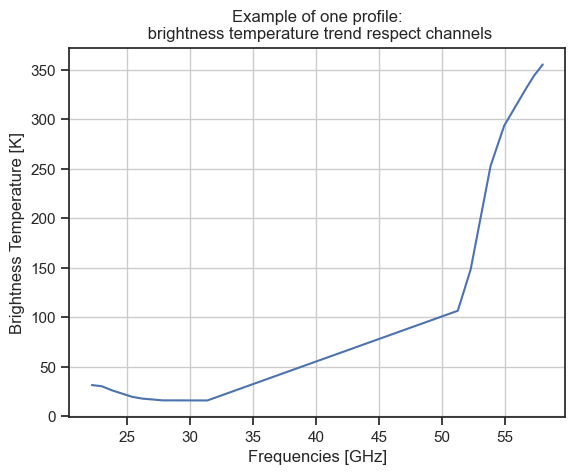

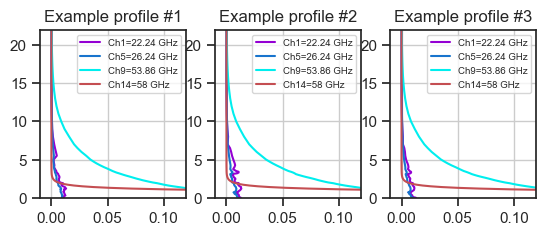

In [8]:
# Plot of TBs and Weighting Function of three profiles
# Loop to compute TB for any combination (time-profiles X height) inside dataset.
# for j in range(0, len(profile_struct)): # 12857 iterations
for j in range(0, 5):
  
    # Pressure
    pressure = db_clean.bar_pres.values
    P = pressure[j] # 60 values in [Pa]

    # Temperature
    temperatures = db_clean.temp.values
    T = temperatures[j] # 60 values in [K]

    # Relative Humidity
    R_H = RH[j,:] # 60 values in [%]

    # Surface temperature is taken as equal to the temperature of last layer
    T_surf=T[0]+0
    T[10]=T[10]+0

    #---------------end of settings section ----------------------------------
    
    # Inizialization of variables
    TB=np.zeros(np.shape(Frequencies)) # brightness temperature of single profile
    wf1=np.zeros((len(Z),len(Frequencies))) # weigthing functions of single profile

    # Computation of TB
    for iv in range(len(Frequencies)):
        F=Frequencies[iv]
        ka=gas_abs(P, T, R_H, F) # computation of absorption coefficient

        gamma = calc_gamma(ka, Z, len(Z), 0, UMU) 

        T_DN = calc_TB_DN(ka,Z,T,UMU)             # TB emitted by the atmosphere downward

        TB[iv] = T_EXTRA*gamma + T_DN
        
        # Computation of weigthing functions
        for i in range(0,len(Z)):
            wf1[i,iv]=calc_weighting_function(ka,Z,i,UMU,updir=0)
            
    # Storage of weigthing functions in each case
    wf_struct.append([wf1])

    # end of for loop with j index
    
# Plot Brightness temperature trend(freq) respect to the changing of surface temperature    
# Insert inside j-loop to have the all profile TB in a single picture (without plt.show())
fig3 = plt.figure(12)
plt.title("Example of one profile:\n brightness temperature trend respect channels")
plt.grid(color='0.80')
plt.plot(Frequencies, TB)
plt.xlabel("Frequencies [GHz]")
plt.ylabel("Brightness Temperature [K]")

plt.show()

for k in range(0,3):   
    # Comparison of the different plots in three different profiles:  
    # Frequencies=[22.24, 23.04, 23.84, 25.44, 26.24, 27.84, 31.4, 51.26, 52.28, 53.86, 54.94, 56.66, 57.3, 58.] # in GHz
    wf_ch1 = wf_struct[k][0][:,0]
    wf_ch5 = wf_struct[k][0][:,4]    
    wf_ch9 = wf_struct[k][0][:,8]
    wf_ch14 = wf_struct[k][0][:,13]
    fig2 = plt.figure(11)
    plt.subplot(2,3,k+1)
    plt.axis([-0.01, 0.12, 0, 22])
    plt.plot(wf_ch1/10e-4,Z/10e2,color='#9400D3',label="Ch1=22.24 GHz")
    plt.plot(wf_ch5/10e-4,Z/10e2,color='#1874CD',label="Ch5=26.24 GHz")    
    plt.plot(wf_ch9/10e-4,Z/10e2,color='#00EEEE',label="Ch9=53.86 GHz")   
    plt.plot(wf_ch14/10e-4,Z/10e2,color='r',label="Ch14=58 GHz")
    plt.legend(loc='upper right', prop={'size': 7})
    plt.grid(color='0.80')
    plt.title("Example profile #"+str(k+1))
plt.show()

# print("done")


In [9]:
# # TB of overall profiles (12857) for each frequency (14) -> 179998 iterations
print("The computation of overall Brightness temperatures (TB)\n" 
      "respect each profile requires a lot of computational time!\n")

# Inizialization of matrix Profile X Brightness Temperature
profXTB = np.zeros((len(profile_struct),len(Frequencies)))

counter = 0

# Loop to compute TB for any combination (time-profiles X height) inside dataset.
# for j in range(0, 10): # this is a loop test

for j in range(0, len(profile_struct)): # loop of 12857 iterations
  
    # Pressure
    pressure = db_clean.bar_pres.values
    P = pressure[j] # 60 values in [Pa]

    # Temperature
    temperatures = db_clean.temp.values
    T = temperatures[j] # 60 values in [K]

#     # Specific Humidity to Relative Humidity
#     # Calculate the relative humidity from specific humidity of air, air temperature, and Total atmospheric pressure
#     # metpy.calc.relative_humidity_from_specific_humidity(pressure, temperature, specific_humidity)    
#     specific_humidities = db_clean.q.values # 12862 values in [g/kg]
#     rel_humidities = relative_humidity_from_specific_humidity(pressure[j]*units.Pa, 
#                                                               temperatures[j]*units.kelvin, 
#                                                               specific_humidities[j]*(10**(-3))).to('percent') # 12862 values
#     RH = rel_humidities # 60 values in [%]
    R_H = RH[j,:]
    # Surface temperature is taken as equal to the temperature of last layer
    T_surf=T[0]+0
    T[10]=T[10]+0
    
    #---------------end of settings section ----------------------------------

    # Inizialization of TB
    TB=np.zeros(np.shape(Frequencies)) # brightness temperature of single profile

    # Computation of TB
    for iv in range(len(Frequencies)): # loop of 14 iter
        F=Frequencies[iv]
        ka=gas_abs(P, T, R_H, F) # computation of absorption coefficient

        gamma = calc_gamma(ka, Z, len(Z), 0, UMU) # gamma contains: absorption coeff., altitude Z, the observation angle

        T_DN = calc_TB_DN(ka,Z,T,UMU)             # TB emitted by the atmosphere downward

        TB[iv] = T_EXTRA*gamma + T_DN # brightness temperature bottom of atmosphere (BOA) of single profile in clear sky 
        
        # Update of matrix (type=list) profile X TB (12862 x 14)
        profXTB[j][iv] = TB[iv]
        
        # Check for the computational time
        counter += 1
        print("\r"+ str(counter) +"/179998 iterations", end = " ") # update in the same row and in the same position
                                                                   # The loop goes in freeze when it arrives 
                                                                   # at 3168 iterations!
        
    # end of for loop with j index

# Storage in a file.txt
file = open("profXTB.txt", "w")
np.set_printoptions(threshold=sys.maxsize) # used to see the overall saved data inside file.txt
file.write(repr(profXTB))
file.close()

print("done")


The computation of overall Brightness temperatures (TB)
respect each profile requires a lot of computational time!

179998/179998 iterations  done


In [10]:
profXTB[0]

array([ 14.69692379,  14.25465518,  13.04424235,  11.37481702,
        11.01803329,  10.88397399,  12.02168964, 105.7400811 ,
       146.88568378, 246.19246288, 283.24435567, 323.00724463,
       338.62871523, 352.86640305])

#### Insertion of Gaussian white noise

Insertion of Gaussian noise with zero mean value and a std equal to the one used for the error covariance matrix in lab06, at the simulated TBs.

In [11]:
profXTB_white = np.zeros((len(profile_struct),len(Frequencies)))
frequencies = Frequencies
mean = 0              # 0 is the mean of the normal distribution you are choosing from            
std = [0.12026637, 0.10864162, 0.10412012, 0.0918477, 0.10174478, 0.10085633,
        0.10500476, 0.42303663, 0.45658514, 0.26291823, 0.25538793, 0.1773584,
        0.17556195, 0.59489495] # is the array of standard deviations of the normal distribution

nSamp = np.size(profXTB[:,0]) # is the number of elements you get in array noise   
# print(np.size(profXTB_white[:,0])) # 12857; np.size(profXTB_white[0,:]) # 14

for i in range(0, len(frequencies)):
    white_noise = np.random.normal(mean, std[i], nSamp)
    profXTB_white[:,i] = np.add(profXTB[:,i], white_noise)
    
# print(profXTB[0])
# print(profXTB_white[0])
# plt.plot(frequencies, profXTB[0])
# plt.show()
# plt.plot(frequencies, profXTB_white[0])
# plt.show()
# plt.plot(profXTB)
# plt.show()
# plt.plot(profXTB_white)
# plt.show()

# Update of profXTB with profXTB_white
profXTB_without_noise = profXTB # storage of TB without noise
profXTB = profXTB_white


## 3rd point
Split the dataset (with profiles and simulated TBs) into two large training and validation dataset removing from the dataset the same few profiles used for test in lab06.

After loading the data in xarray format, which is one of the most common Python libraries to process netcdf files, the data is transformed into tensors which is the standard format for training Machine Learning or Deep Learning models.
For the purpose of this project, it will be used the Tensorflow framework, which is built on top of Keras Python library in order to train a Neural Network.
<!-- In Lab06 is observed that the features dataset have 61906 different records and 13 features, whereas the label dataset consist of one variable and 61906 records. It's applied the same using the dataset of this project. -->

In [12]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras import utils
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import xarray as xr
import warnings
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")

# profXTB (matrix of overall computated TBs profile (12857) respect each frequency (14))
rows_TB = np.size(profXTB[:,0]) # 12857 rows
col_TB = np.size(profXTB[0,:]) # 14 col 

# ######## TB splitting dataset ##########
# numpy to pandas dataframe
train_TB = pd.DataFrame(profXTB[0:rows_TB:2,:])
test_TB =  pd.DataFrame(profXTB[1:rows_TB:2,:])

print("train_TB", np.size(train_TB))
print("test_TB", np.size(test_TB))

# To select a value inside train_TB pandas dataframe you select the col (0 to 13) and than you select the row (0 to 6428)
# Same for test, just different # of rows.
# print(train_TB) # train_TB[13][6428] (last value of the dataframe col [14] x rows [6429])
# print(test_TB) # test_TB[13][6427] (last value of the dataframe col [14] x rows [6428])

# tf.convert_to_tensor(numpy_array) is the method to convert a numpy array in a tensor!
tensor_train_TB = tf.convert_to_tensor(train_TB) # train dataset of TB
tensor_test_TB = tf.convert_to_tensor(test_TB) # test dataset of TB

print("tensor_train_TB", np.size(tensor_train_TB))
print("tensor_test_TB", np.size(tensor_test_TB))

# With tensor, to select inside tensor_train_TB you enter like np.array i.e. rows [6429] x col [14]
# Same for test, just different # of rows.
# print(tensor_train_TB)
# print(test_train_TB)

TB_train = tensor_train_TB
TB_test = tensor_test_TB

# ######## Time and Height splitting dataset (db_clean) #########
# to_dataframe() -> Dataset as a pandas DataFrame.
# DataFrame.unstack() -> Returns a DataFrame having a new level of column labels 
                        # whose inner-most level consists of the pivoted index labels.
                        # If the index is not a MultiIndex, the output will be a Series 
                        # (the analogue of stack when the columns are not a MultiIndex).
                        # Without unstack, I have a single col with all values
    
time_df = db_clean['time'].to_dataframe().unstack() # time is type string
height_df = db_clean['height'].to_dataframe().unstack() # height is type float32
temp_df = db_clean['temp'].to_dataframe().unstack() # real temperature extracted by dataset -> needed to build ANN
q_df = db_clean['q'].to_dataframe().unstack() # specific humidity
bar_df = db_clean['bar_pres'].to_dataframe().unstack() # pressure in Pascal

# print(time_df) # 1D by 12857 values (0 to 12856)
# print(height_df) # 1D by 60 values (0 to 59)

print('The shape of the "time" data is', time_df.shape)
print('The shape of the "height" data is', height_df.shape)
print('The shape of the real temperature "temp" data is', temp_df.shape)
print('The shape of the specific humidity "q" data is', q_df.shape)
print('The shape of the pressure in Pascal "bar_pres" data is', bar_df.shape)

tensor_time_df = tf.convert_to_tensor(time_df, dtype=float)
tensor_height_df = tf.convert_to_tensor(height_df, dtype=float)
tensor_temp_df = tf.convert_to_tensor(temp_df, dtype=float)
tensor_q_df = tf.convert_to_tensor(q_df, dtype=float)
tensor_bar_df = tf.convert_to_tensor(bar_df, dtype=float)

# print(tensor_time_df) # 1D by 12857 values (0 to 12856)
# print(tensor_height_df) # 1D by 60 values (0 to 59)

# Splitting step of db_clean
rows_t = len(db_clean.time)  # number of rows (12857)
rows_h = len(db_clean.height)  # number of columns (60)
rows_temp = len(db_clean.temp)
rows_q = len(db_clean.q)
rows_bar = len(db_clean.bar_pres)

time_train = tensor_time_df[0:rows_t:2]
time_test = tensor_time_df[1:rows_t:2]

height_train = tensor_height_df[0:rows_h:2]
height_test = tensor_height_df[1:rows_h:2] 

temp_train = tensor_temp_df[0:rows_temp:2,:]
temp_test = tensor_temp_df[1:rows_temp:2,:] 

q_train = tensor_q_df[0:rows_q:2,:]
q_test = tensor_q_df[1:rows_q:2,:] 

bar_train = tensor_bar_df[0:rows_bar:2,:]
bar_test = tensor_bar_df[1:rows_bar:2,:] 


train_TB 90006
test_TB 89992
tensor_train_TB 90006
tensor_test_TB 89992
The shape of the "time" data is (12857,)
The shape of the "height" data is (60,)
The shape of the real temperature "temp" data is (12857, 60)
The shape of the specific humidity "q" data is (12857, 60)
The shape of the pressure in Pascal "bar_pres" data is (12857, 60)


In [13]:
# Scaling: Standardize features by removing the mean and scaling to unit variance.
scaler = StandardScaler()
TB_train_scaled = scaler.fit_transform(TB_train) #mean and variance are calculated on the training dataset and applied to the training dataset
TB_test_scaled = scaler.transform(TB_test)       #mean and variance (previously calculated) are applied to the test dataset

print(TB_train.shape)
print(TB_test.shape)
print(temp_train.shape)
print(temp_test.shape)
print(q_train.shape)
print(q_test.shape)
print(bar_train.shape)
print(bar_test.shape)
# TB_train



(6429, 14)
(6428, 14)
(6429, 60)
(6428, 60)
(6429, 60)
(6428, 60)
(6429, 60)
(6428, 60)


## 4th point 
Modify the code in lab07 for training a neural network for the sounding of T and q, using the dataset in 3. Subsequently it's defined the __model hyperparameters__, which influence the model ability to learn.

<figure>
<img src="images/nn_img.png" alt="Architecture of Neural Network" />
<center><figcaption>Fig 1.7: Architecture of Neural Network.</figcaption></center>
</figure>

<br><br>
- The __learning rate__ is the model speed of the learning process: a too high learning rate can save some training time at the expenses of letting the model converge (i.e., minimizing the loss function); a small learning rate can significantly increase the training time and still fail to achieve an efficient minimum. By default, NNs are trained with a decreasing linear schedule, allowing for a constant decrease in the learning rate which helps the model converge.
<br>
- The __batch size__ is the number of samples to include in a single training iteration. The total number of batches can be obtained from: size of the training data/batch_size.
<br>
- The number of __epochs__ is the number times that the learning algorithm will work through the entire training dataset.
<br>
- Finally, setting the __verbose__ option equal to 1 allow us to obtain information on the training while in progress.

####  Training a neural network for the sounding of Temperature case
The used model hyperparameters are:
- learning_rate: 0.0005
- epochs: 1000
- batch_size: 128
- verbose: 1

To anticipate, in the following code, the number of hidden layers and their perceptrons (or neurons) is also chosen.


In [14]:
# model hyperparameters (starting values: 0.01, 1000, 500, 20, 10)
# The recommendation is to choose small batch size with low learning rate.
learning_rate1= 0.0005  # the learning rate is the step size at each iteration while moving toward a minimum of a loss function
epochs = 1000          # An epoch in machine learning means one complete pass of the training dataset through the algorithm.
                       # The right number of epochs depends on the inherent perplexity (or complexity) of your dataset. 
                       # A good rule of thumb is to start with a value that is 3 times the number of columns in your data.
# batch_size = 8000      # the batch size is the number of training examples utilized in one iteration. 
                         # A large batch size should make the training faster but may lead to memory saturation
# batch_size = 32 # there will need 30 minutes of computational time 
batch_size = 128 # A good default for batch size might be 32. Also try 32, 64, 128, 256, and so on.

num_percept_layer1=60  #number of perceptron (or neuron) 1st hidden layer
num_percept_layer2=40  #number of perceptron (or neuron) 2nd hidden layer
output_percept=len(heights)

verbose = 1
# Set the input shape
input_shape = TB_train.shape[1]
print(f'Feature shape: {input_shape}')

Feature shape: 14


#### Model training

Simple model architecture given the training dataset is created. The MLP model is built with:
- Two hidden layers;
- The first layer contains 60 perceptrons, while the second is made of 40 perceptrons; 
- Sigmoid activation function is used as transfer function in both hidden layers;
- The mean squared error (MSE) as loss function to be minimised and display the mean average error (MAE) for each training iteration (epoch).
<br> By printing the model it is possible to observe the shape of each layer and the total number of weights to be updated with the training. 

In [15]:
# training phase with the training dataset
def train():
    # here the network achitecture is defined: it is a feed forward neural network with 2 hidden layers, 
    # 60 perceptrons in the fisrt hidden layer and 40 in the second. 
    # Sigmoids are used as transfer function in both hidden layers.
    model = Sequential()
    model.add(Dense(num_percept_layer1, input_dim=input_shape, kernel_initializer='normal', activation='sigmoid')) ###1st hidden
    model.add(Dense(num_percept_layer2, kernel_initializer='normal', activation='sigmoid')) ###second hidden
    model.add(Dense(output_percept, kernel_initializer='normal', activation='linear')) #output
    model.summary()
    # the optimizer is the algorithm used for the training. Adam is a standard choice, 
    # but Scale conjugate gradient (SGD), is also very efficient.
    optimizer = optimizers.Adam(lr=learning_rate1)
    #optimizer = optimizers.experimental.SGD( learning_rate=learning_rate1)
    
    # here the model optimzer and the loss function to be minimized during training (mean squared error, MSE) are defined
    # the mean absolute error (mae) is also computed as additional metrics
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae']) 
    
    # the training dataset, the batch size and the number of epochs to be used re defined
    history = model.fit(
        TB_train_scaled,
        temp_train,
        batch_size=batch_size,
        epochs=epochs,
    # validation is also carried out
    # monitoring loss and metrics on the test dataset
    # at the end of each epoch
        validation_data=(TB_test_scaled, temp_test),)
    model.save('./mlp_model.h5') #the model is saved at the end of the training phase in an HFD5 output file
    return model, history

##### Start of training process

In [16]:
# for trainig with CPU (Slower) uncomment next line.
model, history = train() 

# for trainig with GPU (Faster) uncomment next 2 lines. works in colab with GPU enabled
# with tf.device("/device:GPU:0"):
#     model, history = train()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60)                900       
                                                                 
 dense_1 (Dense)             (None, 40)                2440      
                                                                 
 dense_2 (Dense)             (None, 60)                2460      
                                                                 
Total params: 5,800
Trainable params: 5,800
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
51/51 [==============================] - 2s 14ms/step - loss: 64004.1367 - mae: 252.2181 - val_loss: 63791.2812 - val_mae: 251.7961
Epoch 2/1000
51/51 [==============================] - 0s 7ms/step - loss: 63511.9023 - mae: 251.2403 - val_loss: 63169.6523 - val_mae: 250.5585
Epoch 3/1000
51/51 [=========

Epoch 52/1000
51/51 [==============================] - 0s 8ms/step - loss: 39930.0586 - mae: 198.8614 - val_loss: 39726.9062 - val_mae: 198.3503
Epoch 53/1000
51/51 [==============================] - 0s 7ms/step - loss: 39544.0977 - mae: 197.8889 - val_loss: 39342.0977 - val_mae: 197.3785
Epoch 54/1000
51/51 [==============================] - 0s 7ms/step - loss: 39160.4258 - mae: 196.9177 - val_loss: 38959.6797 - val_mae: 196.4080
Epoch 55/1000
51/51 [==============================] - 0s 7ms/step - loss: 38779.0508 - mae: 195.9474 - val_loss: 38579.4219 - val_mae: 195.4382
Epoch 56/1000
51/51 [==============================] - 0s 8ms/step - loss: 38399.9766 - mae: 194.9786 - val_loss: 38201.6953 - val_mae: 194.4700
Epoch 57/1000
51/51 [==============================] - 0s 7ms/step - loss: 38023.2188 - mae: 194.0107 - val_loss: 37826.0703 - val_mae: 193.5024
Epoch 58/1000
51/51 [==============================] - 0s 7ms/step - loss: 37648.6641 - mae: 193.0437 - val_loss: 37452.7773 - val

51/51 [==============================] - 0s 7ms/step - loss: 9427.2373 - mae: 95.3698 - val_loss: 9339.5381 - val_mae: 94.9117
Epoch 165/1000
51/51 [==============================] - 0s 7ms/step - loss: 9261.1982 - mae: 94.4994 - val_loss: 9174.3496 - val_mae: 94.0420
Epoch 166/1000
51/51 [==============================] - 0s 7ms/step - loss: 9096.8730 - mae: 93.6305 - val_loss: 9010.9766 - val_mae: 93.1738
Epoch 167/1000
51/51 [==============================] - 0s 7ms/step - loss: 8934.2725 - mae: 92.7630 - val_loss: 8849.3418 - val_mae: 92.3070
Epoch 168/1000
51/51 [==============================] - 0s 7ms/step - loss: 8773.4355 - mae: 91.8962 - val_loss: 8689.3848 - val_mae: 91.4412
Epoch 169/1000
51/51 [==============================] - 0s 7ms/step - loss: 8614.3701 - mae: 91.0323 - val_loss: 8531.3359 - val_mae: 90.5777
Epoch 170/1000
51/51 [==============================] - 0s 7ms/step - loss: 8457.0908 - mae: 90.1687 - val_loss: 8374.8447 - val_mae: 89.7147
Epoch 171/1000
51/51 

Epoch 222/1000
51/51 [==============================] - 0s 8ms/step - loss: 2547.8533 - mae: 47.8345 - val_loss: 2509.2725 - val_mae: 47.4390
Epoch 223/1000
51/51 [==============================] - 0s 9ms/step - loss: 2475.0491 - mae: 47.0857 - val_loss: 2437.1143 - val_mae: 46.6919
Epoch 224/1000
51/51 [==============================] - 1s 12ms/step - loss: 2403.6016 - mae: 46.3408 - val_loss: 2366.3865 - val_mae: 45.9485
Epoch 225/1000
51/51 [==============================] - 1s 12ms/step - loss: 2333.5845 - mae: 45.5993 - val_loss: 2297.0952 - val_mae: 45.2091
Epoch 226/1000
51/51 [==============================] - 1s 13ms/step - loss: 2264.9167 - mae: 44.8620 - val_loss: 2229.2173 - val_mae: 44.4735
Epoch 227/1000
51/51 [==============================] - 1s 11ms/step - loss: 2197.6685 - mae: 44.1278 - val_loss: 2162.6519 - val_mae: 43.7411
Epoch 228/1000
51/51 [==============================] - 0s 8ms/step - loss: 2131.7410 - mae: 43.3970 - val_loss: 2097.4619 - val_mae: 43.0123
Ep

51/51 [==============================] - 0s 7ms/step - loss: 274.0736 - mae: 13.4626 - val_loss: 267.3780 - val_mae: 13.2759
Epoch 281/1000
51/51 [==============================] - 0s 7ms/step - loss: 261.5853 - mae: 13.1218 - val_loss: 255.2383 - val_mae: 12.9418
Epoch 282/1000
51/51 [==============================] - 0s 7ms/step - loss: 249.6534 - mae: 12.7912 - val_loss: 243.5896 - val_mae: 12.6174
Epoch 283/1000
51/51 [==============================] - 0s 7ms/step - loss: 238.3038 - mae: 12.4741 - val_loss: 232.5499 - val_mae: 12.3065
Epoch 284/1000
51/51 [==============================] - 0s 7ms/step - loss: 227.4913 - mae: 12.1678 - val_loss: 222.0385 - val_mae: 12.0066
Epoch 285/1000
51/51 [==============================] - 0s 7ms/step - loss: 217.2065 - mae: 11.8731 - val_loss: 212.0204 - val_mae: 11.7180
Epoch 286/1000
51/51 [==============================] - 0s 7ms/step - loss: 207.4526 - mae: 11.5898 - val_loss: 202.5177 - val_mae: 11.4412
Epoch 287/1000
51/51 [=============

Epoch 340/1000
51/51 [==============================] - 0s 9ms/step - loss: 24.4863 - mae: 3.6877 - val_loss: 24.3510 - val_mae: 3.6986
Epoch 341/1000
51/51 [==============================] - 0s 9ms/step - loss: 24.0382 - mae: 3.6460 - val_loss: 23.8916 - val_mae: 3.6378
Epoch 342/1000
51/51 [==============================] - 0s 9ms/step - loss: 23.6144 - mae: 3.6048 - val_loss: 23.4806 - val_mae: 3.6005
Epoch 343/1000
51/51 [==============================] - 0s 8ms/step - loss: 23.2182 - mae: 3.5649 - val_loss: 23.0937 - val_mae: 3.5728
Epoch 344/1000
51/51 [==============================] - 0s 8ms/step - loss: 22.8295 - mae: 3.5292 - val_loss: 22.6975 - val_mae: 3.5147
Epoch 345/1000
51/51 [==============================] - 0s 8ms/step - loss: 22.4555 - mae: 3.4880 - val_loss: 22.3233 - val_mae: 3.4766
Epoch 346/1000
51/51 [==============================] - 0s 8ms/step - loss: 22.0962 - mae: 3.4523 - val_loss: 21.9754 - val_mae: 3.4353
Epoch 347/1000
51/51 [==========================

51/51 [==============================] - 0s 9ms/step - loss: 11.7525 - mae: 2.3495 - val_loss: 11.7656 - val_mae: 2.3504
Epoch 461/1000
51/51 [==============================] - 0s 9ms/step - loss: 11.7088 - mae: 2.3439 - val_loss: 11.7166 - val_mae: 2.3415
Epoch 462/1000
51/51 [==============================] - 0s 9ms/step - loss: 11.6667 - mae: 2.3386 - val_loss: 11.6742 - val_mae: 2.3366
Epoch 463/1000
51/51 [==============================] - 0s 8ms/step - loss: 11.6245 - mae: 2.3339 - val_loss: 11.6336 - val_mae: 2.3359
Epoch 464/1000
51/51 [==============================] - 0s 8ms/step - loss: 11.5812 - mae: 2.3299 - val_loss: 11.5912 - val_mae: 2.3304
Epoch 465/1000
51/51 [==============================] - 0s 8ms/step - loss: 11.5406 - mae: 2.3280 - val_loss: 11.5505 - val_mae: 2.3247
Epoch 466/1000
51/51 [==============================] - 0s 8ms/step - loss: 11.4977 - mae: 2.3216 - val_loss: 11.5100 - val_mae: 2.3257
Epoch 467/1000
51/51 [==============================] - 0s 7ms/

51/51 [==============================] - 0s 9ms/step - loss: 9.3008 - mae: 2.1090 - val_loss: 9.3127 - val_mae: 2.1087
Epoch 582/1000
51/51 [==============================] - 0s 8ms/step - loss: 9.2951 - mae: 2.1082 - val_loss: 9.3096 - val_mae: 2.1089
Epoch 583/1000
51/51 [==============================] - 0s 8ms/step - loss: 9.2896 - mae: 2.1082 - val_loss: 9.3040 - val_mae: 2.1072
Epoch 584/1000
51/51 [==============================] - 0s 8ms/step - loss: 9.2845 - mae: 2.1066 - val_loss: 9.2974 - val_mae: 2.1066
Epoch 585/1000
51/51 [==============================] - 0s 7ms/step - loss: 9.2788 - mae: 2.1058 - val_loss: 9.2946 - val_mae: 2.1077
Epoch 586/1000
51/51 [==============================] - 0s 7ms/step - loss: 9.2743 - mae: 2.1061 - val_loss: 9.2930 - val_mae: 2.1066
Epoch 587/1000
51/51 [==============================] - 0s 7ms/step - loss: 9.2703 - mae: 2.1066 - val_loss: 9.2832 - val_mae: 2.1037
Epoch 588/1000
51/51 [==============================] - 0s 7ms/step - loss: 9

51/51 [==============================] - 0s 7ms/step - loss: 8.9563 - mae: 2.0705 - val_loss: 8.9723 - val_mae: 2.0719
Epoch 704/1000
51/51 [==============================] - 0s 7ms/step - loss: 8.9550 - mae: 2.0716 - val_loss: 8.9689 - val_mae: 2.0702
Epoch 705/1000
51/51 [==============================] - 0s 7ms/step - loss: 8.9522 - mae: 2.0690 - val_loss: 8.9684 - val_mae: 2.0706
Epoch 706/1000
51/51 [==============================] - 0s 7ms/step - loss: 8.9529 - mae: 2.0701 - val_loss: 8.9665 - val_mae: 2.0709
Epoch 707/1000
51/51 [==============================] - 0s 7ms/step - loss: 8.9500 - mae: 2.0699 - val_loss: 8.9653 - val_mae: 2.0700
Epoch 708/1000
51/51 [==============================] - 0s 7ms/step - loss: 8.9508 - mae: 2.0698 - val_loss: 8.9635 - val_mae: 2.0700
Epoch 709/1000
51/51 [==============================] - 0s 7ms/step - loss: 8.9466 - mae: 2.0702 - val_loss: 8.9606 - val_mae: 2.0690
Epoch 710/1000
51/51 [==============================] - 0s 7ms/step - loss: 8

51/51 [==============================] - 0s 7ms/step - loss: 8.7546 - mae: 2.0445 - val_loss: 8.7640 - val_mae: 2.0441
Epoch 826/1000
51/51 [==============================] - 0s 7ms/step - loss: 8.7485 - mae: 2.0424 - val_loss: 8.7617 - val_mae: 2.0424
Epoch 827/1000
51/51 [==============================] - 0s 7ms/step - loss: 8.7456 - mae: 2.0421 - val_loss: 8.7599 - val_mae: 2.0412
Epoch 828/1000
51/51 [==============================] - 0s 7ms/step - loss: 8.7444 - mae: 2.0413 - val_loss: 8.7566 - val_mae: 2.0430
Epoch 829/1000
51/51 [==============================] - 0s 7ms/step - loss: 8.7418 - mae: 2.0398 - val_loss: 8.7533 - val_mae: 2.0418
Epoch 830/1000
51/51 [==============================] - 0s 7ms/step - loss: 8.7369 - mae: 2.0421 - val_loss: 8.7587 - val_mae: 2.0405
Epoch 831/1000
51/51 [==============================] - 0s 7ms/step - loss: 8.7400 - mae: 2.0406 - val_loss: 8.7469 - val_mae: 2.0399
Epoch 832/1000
51/51 [==============================] - 0s 7ms/step - loss: 8

51/51 [==============================] - 0s 7ms/step - loss: 7.4233 - mae: 1.8628 - val_loss: 7.4312 - val_mae: 1.8623
Epoch 948/1000
51/51 [==============================] - 0s 7ms/step - loss: 7.4151 - mae: 1.8602 - val_loss: 7.4267 - val_mae: 1.8589
Epoch 949/1000
51/51 [==============================] - 0s 7ms/step - loss: 7.4079 - mae: 1.8589 - val_loss: 7.4148 - val_mae: 1.8591
Epoch 950/1000
51/51 [==============================] - 0s 7ms/step - loss: 7.4011 - mae: 1.8594 - val_loss: 7.4158 - val_mae: 1.8635
Epoch 951/1000
51/51 [==============================] - 0s 7ms/step - loss: 7.3952 - mae: 1.8580 - val_loss: 7.4021 - val_mae: 1.8549
Epoch 952/1000
51/51 [==============================] - 0s 7ms/step - loss: 7.3860 - mae: 1.8574 - val_loss: 7.4059 - val_mae: 1.8571
Epoch 953/1000
51/51 [==============================] - 0s 7ms/step - loss: 7.3815 - mae: 1.8555 - val_loss: 7.3881 - val_mae: 1.8565
Epoch 954/1000
51/51 [==============================] - 0s 7ms/step - loss: 7

#### Model evaluation 

Here there is the plot of the learning curves, i.e., the MAE obtained ad each iteration (epoch) as a function of the epoch number. By observing the learning curves, it's clearly seen that the training and test values of the loss function decrease with the number of epochs. However, the decreasing rate of the two curves slows down, and the two curves become almost flat somewhat near the 300th epoch, which means that the training of the model is almost completed. Moreover, the two (train and test) loss curves are very similar to each other, this is a clear sign of the generalizability of the model. In the small plot it can be appreciated the zoom between the two loss curves (train in blue and test in red). 

<!-- In other terms, if we train on a dataset and we get the same result on an indipendent test dataset (with different observations) we expect that the application of the model to any other dataset will still give the same accuracy (i.e., validation dataset which is not considered in this exercise). 
<br> Overall, it is possible to observe that the two curves do not fully reach and asymptotic value, and it may be possible that a further training of the model brigns to slightly better results.-->


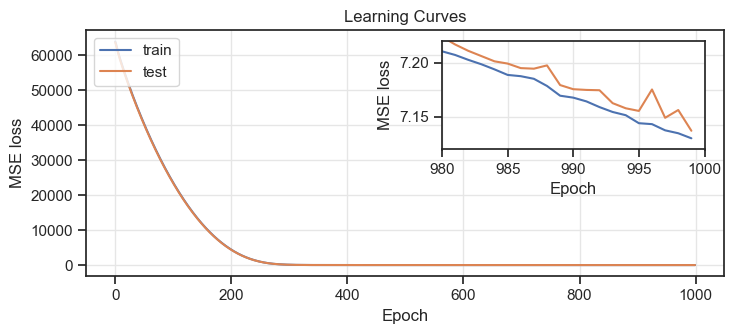

In [21]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
fig, ax1 = plt.subplots()
plt.title("Learning Curves")
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
ax1.plot((history.history['loss']), label="train")
ax1.plot((history.history['val_loss']), label="test")
plt.grid(color='0.90')

l, b, h, w = .6, .55, .31, .35 # position: l and b; dimension: h-height and w-width
ax2 = fig.add_axes([l, b, w, h])
plt.ylim(7.12,7.22)
plt.xlim(980,1000)
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
ax2.plot((history.history['loss']))
ax2.plot((history.history['val_loss']))
ax1.legend(loc='upper left')
plt.grid(color='0.90')
plt.show()


In [22]:
# ANN Temperature
temp_pred = model.predict(TB_test_scaled)


201/201 [==============================] - 1s 2ms/step


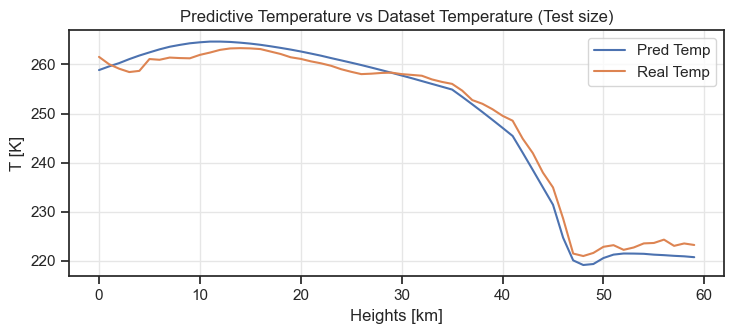

In [23]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.title("Predictive Temperature vs Dataset Temperature (Test size)")
plt.plot(temp_pred[0], label='Pred Temp')
plt.plot(temp_test[0], label='Real Temp')
plt.xlabel('Heights [km]')
plt.ylabel('T [K]')
plt.grid(color='0.90')
plt.legend()
plt.show()

#### Further training of the model

The model can be further trained for even more Epochs to check if it will be subject to overfitting. An overfitting model reproduces too closely the target variable in a specific training dataset, and may therefore fail to fit additional data or predict future observations reliably. In other words, the model memorizes the training dataset too well, learning also the noise included, and it is not able to generalise any more. <br>The following code loads the model that has been trained in section 6 and trains it further for **additional 1000 epochs**, using the same training hyperparameters (learning rate, batch size, etc.).

In [24]:
# training phase with the training dataset
fine_tune_epochs = 1000
total_epochs =  epochs + fine_tune_epochs
def train_fine(model):

    optimizer = optimizers.Adam(lr=learning_rate1)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    history_fine = model.fit(
        TB_train_scaled,
        temp_train,
        batch_size=batch_size,
        epochs=total_epochs,
        initial_epoch=history.epoch[-1],
    # it also be carried out some validation to
    # monitor loss and metrics on the test dataset
    # at the end of each epoch
        validation_data=(TB_test_scaled, temp_test),)
        #validation_data=(X_test, np.log10(y_test)),)
    model.save('./mlp_model_1.h5')
    return model, history_fine
new_model = tf.keras.models.load_model('./mlp_model.h5')

# for trainig with CPU (Slower) uncomment next line.
# model_fine, history_fine = train_fine(new_model)

# for trainig with GPU (Faster) uncomment next 2 lines. works in colab with GPU enabled
with tf.device("/device:GPU:0"):
    model_fine, history_fine = train_fine(new_model)


Epoch 1000/2000
51/51 [==============================] - 2s 19ms/step - loss: 7.1270 - mae: 1.8129 - val_loss: 7.1374 - val_mae: 1.8142
Epoch 1001/2000
51/51 [==============================] - 0s 9ms/step - loss: 7.1249 - mae: 1.8146 - val_loss: 7.1305 - val_mae: 1.8123
Epoch 1002/2000
51/51 [==============================] - 0s 7ms/step - loss: 7.1173 - mae: 1.8110 - val_loss: 7.1252 - val_mae: 1.8123
Epoch 1003/2000
51/51 [==============================] - 0s 7ms/step - loss: 7.1152 - mae: 1.8114 - val_loss: 7.1301 - val_mae: 1.8119
Epoch 1004/2000
51/51 [==============================] - 0s 7ms/step - loss: 7.1084 - mae: 1.8108 - val_loss: 7.1179 - val_mae: 1.8117
Epoch 1005/2000
51/51 [==============================] - 0s 8ms/step - loss: 7.1038 - mae: 1.8084 - val_loss: 7.1147 - val_mae: 1.8106
Epoch 1006/2000
51/51 [==============================] - 0s 8ms/step - loss: 7.1018 - mae: 1.8089 - val_loss: 7.1105 - val_mae: 1.8097
Epoch 1007/2000
51/51 [==============================]

Epoch 1121/2000
51/51 [==============================] - 0s 7ms/step - loss: 6.8204 - mae: 1.7589 - val_loss: 6.8314 - val_mae: 1.7585
Epoch 1122/2000
51/51 [==============================] - 0s 7ms/step - loss: 6.8228 - mae: 1.7592 - val_loss: 6.8268 - val_mae: 1.7595
Epoch 1123/2000
51/51 [==============================] - 0s 9ms/step - loss: 6.8146 - mae: 1.7561 - val_loss: 6.8343 - val_mae: 1.7609
Epoch 1124/2000
51/51 [==============================] - 0s 9ms/step - loss: 6.8153 - mae: 1.7585 - val_loss: 6.8237 - val_mae: 1.7582
Epoch 1125/2000
51/51 [==============================] - 0s 9ms/step - loss: 6.8091 - mae: 1.7565 - val_loss: 6.8216 - val_mae: 1.7585
Epoch 1126/2000
51/51 [==============================] - 0s 8ms/step - loss: 6.8116 - mae: 1.7565 - val_loss: 6.8212 - val_mae: 1.7603
Epoch 1127/2000
51/51 [==============================] - 0s 8ms/step - loss: 6.8074 - mae: 1.7570 - val_loss: 6.8259 - val_mae: 1.7589
Epoch 1128/2000
51/51 [==============================] 

Epoch 1242/2000
51/51 [==============================] - 0s 8ms/step - loss: 6.6650 - mae: 1.7319 - val_loss: 6.6706 - val_mae: 1.7313
Epoch 1243/2000
51/51 [==============================] - 0s 9ms/step - loss: 6.6578 - mae: 1.7296 - val_loss: 6.6717 - val_mae: 1.7322
Epoch 1244/2000
51/51 [==============================] - 0s 9ms/step - loss: 6.6591 - mae: 1.7304 - val_loss: 6.6684 - val_mae: 1.7307
Epoch 1245/2000
51/51 [==============================] - 0s 9ms/step - loss: 6.6560 - mae: 1.7291 - val_loss: 6.6729 - val_mae: 1.7320
Epoch 1246/2000
51/51 [==============================] - 0s 9ms/step - loss: 6.6594 - mae: 1.7297 - val_loss: 6.6640 - val_mae: 1.7309
Epoch 1247/2000
51/51 [==============================] - 0s 9ms/step - loss: 6.6536 - mae: 1.7280 - val_loss: 6.6675 - val_mae: 1.7314
Epoch 1248/2000
51/51 [==============================] - 0s 9ms/step - loss: 6.6543 - mae: 1.7290 - val_loss: 6.6610 - val_mae: 1.7291
Epoch 1249/2000
51/51 [==============================] 

Epoch 1363/2000
51/51 [==============================] - 0s 9ms/step - loss: 6.5621 - mae: 1.7158 - val_loss: 6.5707 - val_mae: 1.7168
Epoch 1364/2000
51/51 [==============================] - 0s 9ms/step - loss: 6.5634 - mae: 1.7144 - val_loss: 6.5925 - val_mae: 1.7255
Epoch 1365/2000
51/51 [==============================] - 0s 9ms/step - loss: 6.5642 - mae: 1.7176 - val_loss: 6.5674 - val_mae: 1.7148
Epoch 1366/2000
51/51 [==============================] - 0s 9ms/step - loss: 6.5556 - mae: 1.7139 - val_loss: 6.5623 - val_mae: 1.7156
Epoch 1367/2000
51/51 [==============================] - 0s 8ms/step - loss: 6.5558 - mae: 1.7151 - val_loss: 6.5652 - val_mae: 1.7134
Epoch 1368/2000
51/51 [==============================] - 0s 8ms/step - loss: 6.5548 - mae: 1.7136 - val_loss: 6.5595 - val_mae: 1.7139
Epoch 1369/2000
51/51 [==============================] - 0s 8ms/step - loss: 6.5535 - mae: 1.7120 - val_loss: 6.5636 - val_mae: 1.7161
Epoch 1370/2000
51/51 [==============================] 

Epoch 1484/2000
51/51 [==============================] - 0s 8ms/step - loss: 6.4758 - mae: 1.7040 - val_loss: 6.4813 - val_mae: 1.7037
Epoch 1485/2000
51/51 [==============================] - 0s 8ms/step - loss: 6.4746 - mae: 1.7024 - val_loss: 6.4981 - val_mae: 1.7062
Epoch 1486/2000
51/51 [==============================] - 0s 7ms/step - loss: 6.4735 - mae: 1.7033 - val_loss: 6.4834 - val_mae: 1.7045
Epoch 1487/2000
51/51 [==============================] - 0s 7ms/step - loss: 6.4739 - mae: 1.7023 - val_loss: 6.4838 - val_mae: 1.7040
Epoch 1488/2000
51/51 [==============================] - 0s 7ms/step - loss: 6.4734 - mae: 1.7029 - val_loss: 6.4813 - val_mae: 1.7052
Epoch 1489/2000
51/51 [==============================] - 0s 7ms/step - loss: 6.4707 - mae: 1.7030 - val_loss: 6.4859 - val_mae: 1.7040
Epoch 1490/2000
51/51 [==============================] - 0s 7ms/step - loss: 6.4687 - mae: 1.7020 - val_loss: 6.4872 - val_mae: 1.7050
Epoch 1491/2000
51/51 [==============================] 

Epoch 1605/2000
51/51 [==============================] - 0s 7ms/step - loss: 6.3914 - mae: 1.6923 - val_loss: 6.3951 - val_mae: 1.6955
Epoch 1606/2000
51/51 [==============================] - 0s 7ms/step - loss: 6.3879 - mae: 1.6927 - val_loss: 6.3926 - val_mae: 1.6910
Epoch 1607/2000
51/51 [==============================] - 0s 7ms/step - loss: 6.3909 - mae: 1.6940 - val_loss: 6.4041 - val_mae: 1.6966
Epoch 1608/2000
51/51 [==============================] - 0s 7ms/step - loss: 6.3948 - mae: 1.6949 - val_loss: 6.4149 - val_mae: 1.6966
Epoch 1609/2000
51/51 [==============================] - 0s 7ms/step - loss: 6.3882 - mae: 1.6923 - val_loss: 6.3917 - val_mae: 1.6934
Epoch 1610/2000
51/51 [==============================] - 0s 7ms/step - loss: 6.3866 - mae: 1.6928 - val_loss: 6.3959 - val_mae: 1.6910
Epoch 1611/2000
51/51 [==============================] - 0s 7ms/step - loss: 6.3863 - mae: 1.6920 - val_loss: 6.3923 - val_mae: 1.6921
Epoch 1612/2000
51/51 [==============================] 

Epoch 1726/2000
51/51 [==============================] - 0s 7ms/step - loss: 6.3105 - mae: 1.6842 - val_loss: 6.3174 - val_mae: 1.6865
Epoch 1727/2000
51/51 [==============================] - 0s 7ms/step - loss: 6.3116 - mae: 1.6843 - val_loss: 6.3124 - val_mae: 1.6825
Epoch 1728/2000
51/51 [==============================] - 0s 7ms/step - loss: 6.3091 - mae: 1.6844 - val_loss: 6.3181 - val_mae: 1.6860
Epoch 1729/2000
51/51 [==============================] - 0s 7ms/step - loss: 6.3043 - mae: 1.6819 - val_loss: 6.3119 - val_mae: 1.6867
Epoch 1730/2000
51/51 [==============================] - 0s 7ms/step - loss: 6.3115 - mae: 1.6856 - val_loss: 6.3178 - val_mae: 1.6854
Epoch 1731/2000
51/51 [==============================] - 0s 7ms/step - loss: 6.3083 - mae: 1.6833 - val_loss: 6.3277 - val_mae: 1.6886
Epoch 1732/2000
51/51 [==============================] - 0s 7ms/step - loss: 6.3090 - mae: 1.6853 - val_loss: 6.3068 - val_mae: 1.6841
Epoch 1733/2000
51/51 [==============================] 

Epoch 1847/2000
51/51 [==============================] - 0s 7ms/step - loss: 6.2315 - mae: 1.6760 - val_loss: 6.2370 - val_mae: 1.6763
Epoch 1848/2000
51/51 [==============================] - 0s 7ms/step - loss: 6.2290 - mae: 1.6759 - val_loss: 6.2323 - val_mae: 1.6721
Epoch 1849/2000
51/51 [==============================] - 0s 7ms/step - loss: 6.2297 - mae: 1.6741 - val_loss: 6.2348 - val_mae: 1.6764
Epoch 1850/2000
51/51 [==============================] - 0s 9ms/step - loss: 6.2265 - mae: 1.6747 - val_loss: 6.2326 - val_mae: 1.6746
Epoch 1851/2000
51/51 [==============================] - 0s 9ms/step - loss: 6.2249 - mae: 1.6737 - val_loss: 6.2335 - val_mae: 1.6777
Epoch 1852/2000
51/51 [==============================] - 0s 9ms/step - loss: 6.2311 - mae: 1.6758 - val_loss: 6.2339 - val_mae: 1.6747
Epoch 1853/2000
51/51 [==============================] - 0s 8ms/step - loss: 6.2230 - mae: 1.6736 - val_loss: 6.2284 - val_mae: 1.6765
Epoch 1854/2000
51/51 [==============================] 

Epoch 1968/2000
51/51 [==============================] - 0s 9ms/step - loss: 6.1553 - mae: 1.6653 - val_loss: 6.1618 - val_mae: 1.6689
Epoch 1969/2000
51/51 [==============================] - 0s 8ms/step - loss: 6.1564 - mae: 1.6662 - val_loss: 6.1708 - val_mae: 1.6722
Epoch 1970/2000
51/51 [==============================] - 0s 9ms/step - loss: 6.1576 - mae: 1.6670 - val_loss: 6.1591 - val_mae: 1.6660
Epoch 1971/2000
51/51 [==============================] - 0s 8ms/step - loss: 6.1522 - mae: 1.6651 - val_loss: 6.1623 - val_mae: 1.6679
Epoch 1972/2000
51/51 [==============================] - 0s 9ms/step - loss: 6.1573 - mae: 1.6654 - val_loss: 6.1551 - val_mae: 1.6656
Epoch 1973/2000
51/51 [==============================] - 0s 9ms/step - loss: 6.1501 - mae: 1.6658 - val_loss: 6.1657 - val_mae: 1.6641
Epoch 1974/2000
51/51 [==============================] - 0s 9ms/step - loss: 6.1503 - mae: 1.6647 - val_loss: 6.1528 - val_mae: 1.6642
Epoch 1975/2000
51/51 [==============================] 

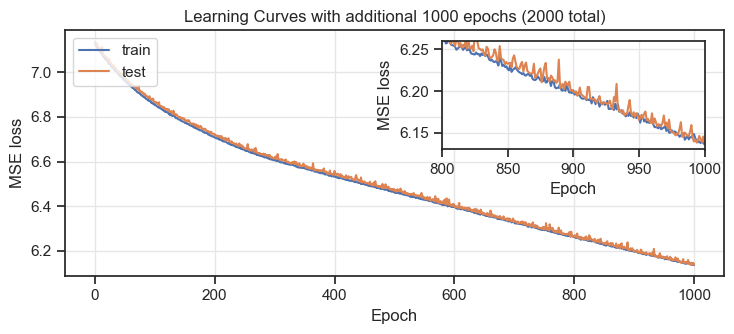

In [26]:
# plot learning curves
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
fig, ax1 = plt.subplots()
plt.title("Learning Curves with additional 1000 epochs (2000 total)")
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
ax1.plot((history_fine.history['loss']), label="train")
ax1.plot((history_fine.history['val_loss']), label="test")
plt.grid(color='0.90')
l, b, h, w = .6, .55, .31, .35 # position: l and b; dimension: h-height and w-width
ax2 = fig.add_axes([l, b, w, h])
plt.ylim(6.13,6.26)
plt.xlim(800,1000)
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
ax2.plot((history_fine.history['loss']))
ax2.plot((history_fine.history['val_loss']))
ax1.legend(loc='upper left')
plt.grid(color='0.90')
plt.show()


#### Comparison trends between the predicted temperature and the stored temperature within the dataset

201/201 [==============================] - 1s 2ms/step


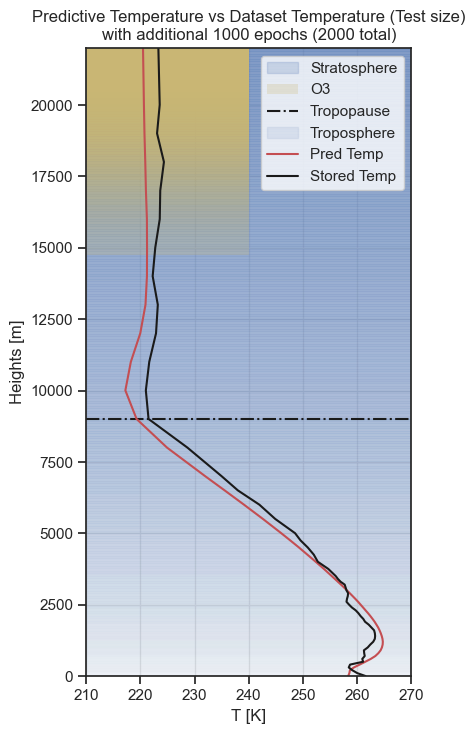

In [27]:
# ANN new temperature
temp_pred_new = model_fine.predict(TB_test_scaled)
tropopause = 9000 # At 9 km at the poles, 17 km at the equator. Not an “hard” barrier, not so easy to define!
walk = 25
plt.rcParams["figure.figsize"] = [4.50, 7.50]
plt.rcParams["figure.autolayout"] = True

plt.title("Predictive Temperature vs Dataset Temperature (Test size)\nwith additional 1000 epochs (2000 total)")
# Stratosphere
plt.axhspan(tropopause, 23000, color="b", facecolor='0.8', alpha=0.2, label="Stratosphere")
for j in range(tropopause, 23000, walk):
    plt.axhspan(0+j, walk+j, color="b", facecolor='0.8', alpha=((j+1)/(4*23000)))
# O3    
plt.axvspan(210, 240, 0.67, 1, facecolor='y', alpha=0.25, label="O3", lw=0)
for k in np.arange(0, 1, 0.01):
    plt.axvspan(210, 240, 0.67+k, 1+k, facecolor='y', alpha=k, lw=0)
# Tropopause
plt.axhline(y=tropopause, color='k', linestyle='-.', label="Tropopause")
# Troposphere
plt.axhspan(0, tropopause, color='b',facecolor='0.9', alpha=0.1, label="Troposphere")
for i in range(0, tropopause, walk):
    plt.axhspan(0+i, walk+i, color='b',facecolor='0.9', alpha=i/(8*tropopause))
# Prediction Temperature vs Stored Temperature    
plt.plot(temp_pred_new[0], heights, color='r', label='Pred Temp')
plt.plot(temp_test[0], heights, color='k', label='Stored Temp')
plt.ylabel('Heights [m]')
plt.xlabel('T [K]')
plt.ylim(0, 22000)
plt.xlim(210,270)
plt.grid(color='0.90')
plt.legend()
plt.show()

####  Training a neural network for the sounding of Specific Humidity case
Implementation of neural network for the estimation of Specific Humidity. The used architecture is the same used for the temperature case. 
#### Hyperparameters for ANN of Specific Humidity

The used model hyperparameters are the same of Temperature case, expection for the epochs.
- learning_rate: 0.0005
- epochs: 1500
- batch_size: 128
- verbose: 1

It is used same number of hidden layers (two) and same number of perceptrons (or neurons), with respect 60 and 40. As the first ANN model in the temperature case, in the following plot it can be seen the learning curves of the MAE obtained at each iteration (epoch) as a function of the epoch number. Also in this case it can be clearly seen that the training and test values of the loss function decrease with the number of epochs very fast; the two curves become almost flat somewhat near the 40th epoch, which means that the training of the model is almost completed.

In [28]:
# model_q hyperparameters (starting values: 0.01, 1000, 500, 20, 10)
# The recommendation is to choose small batch size with low learning rate.
learning_rate1= 0.0005  # the learning rate is the step size at each iteration while moving toward a minimum of a loss function
epochs = 500
batch_size = 128 # A good default for batch size might be 32. Also try 32, 64, 128, 256, and so on.
num_percept_layer1=60  #number of perceptron (or neuron) 1st hidden layer
num_percept_layer2=40  #number of perceptron (or neuron) 2nd hidden layer
output_percept=len(heights)

verbose = 1
# Set the input shape
input_shape = TB_train.shape[1]
print(f'Feature shape: {input_shape}')
# print(f'Feature shape: {TB_train_scaled[:,0].shape}')

Feature shape: 14


#### Training phase with the specific humidity training dataset

In [29]:
# training phase with the training dataset
def train_q():
    # here the network achitecture is defined: it is a feed forward neural network with 2 hidden layers, 
    # 60 perceptrons in the first hidden layer and 40 in the second. 
    # Sigmoids are used as transfer function in both hidden layers.
    model_q = Sequential()
    model_q.add(Dense(num_percept_layer1, input_dim=input_shape, kernel_initializer='normal', activation='sigmoid'))
    model_q.add(Dense(num_percept_layer2, kernel_initializer='normal', activation='sigmoid')) ###second hidden
    model_q.add(Dense(output_percept, kernel_initializer='normal', activation='linear')) #output
    model_q.summary()
    # the optimizer is the algorithm used for the training. Adam is a standard choice,
    # but Scale conjugate gradient (SGD), is also very efficient.
    optimizer = optimizers.Adam(lr=learning_rate1)
    # optimizer = optimizers.experimental.SGD( learning_rate=learning_rate1)
    
    # here the model optimzer and the loss function to be minimized during training (mean squared error, MSE) are defined
    # the mean absolute error (mae) is also computed as additional metrics
    model_q.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae']) 
    
    # the training dataset, the batch size and the number of epochs to be used re defined
    history_q = model_q.fit(
        TB_train_scaled,
        q_train,
        batch_size=batch_size,
        epochs=epochs,
    # validation is also carried out
    # monitoring loss and metrics on the test dataset
    # at the end of each epoch
        validation_data=(TB_test_scaled, q_test),)
    model_q.save('./mlp_model_q.h5') #the model is saved at the end of the training phase in an HFD5 output file
    return model_q, history_q

#### Starting of process

In [30]:
# for trainig with CPU (Slower) uncomment next line.
model_q, history_q = train_q() 


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 60)                900       
                                                                 
 dense_4 (Dense)             (None, 40)                2440      
                                                                 
 dense_5 (Dense)             (None, 60)                2460      
                                                                 
Total params: 5,800
Trainable params: 5,800
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
51/51 [==============================] - 2s 13ms/step - loss: 3.3338 - mae: 1.1258 - val_loss: 2.5764 - val_mae: 0.9500
Epoch 2/500
51/51 [==============================] - 0s 7ms/step - loss: 1.9626 - mae: 0.8407 - val_loss: 1.4649 - val_mae: 0.7570
Epoch 3/500
51/51 [==============================] - 

Epoch 57/500
51/51 [==============================] - 0s 7ms/step - loss: 0.2028 - mae: 0.2764 - val_loss: 0.1997 - val_mae: 0.2755
Epoch 58/500
51/51 [==============================] - 0s 7ms/step - loss: 0.2021 - mae: 0.2757 - val_loss: 0.1995 - val_mae: 0.2747
Epoch 59/500
51/51 [==============================] - 0s 8ms/step - loss: 0.2016 - mae: 0.2753 - val_loss: 0.1985 - val_mae: 0.2740
Epoch 60/500
51/51 [==============================] - 0s 7ms/step - loss: 0.2010 - mae: 0.2746 - val_loss: 0.1979 - val_mae: 0.2737
Epoch 61/500
51/51 [==============================] - 0s 7ms/step - loss: 0.2004 - mae: 0.2741 - val_loss: 0.1974 - val_mae: 0.2736
Epoch 62/500
51/51 [==============================] - 0s 7ms/step - loss: 0.1999 - mae: 0.2737 - val_loss: 0.1969 - val_mae: 0.2725
Epoch 63/500
51/51 [==============================] - 0s 7ms/step - loss: 0.1993 - mae: 0.2731 - val_loss: 0.1964 - val_mae: 0.2725
Epoch 64/500
51/51 [==============================] - 0s 7ms/step - loss: 0.

Epoch 119/500
51/51 [==============================] - 0s 8ms/step - loss: 0.1615 - mae: 0.2368 - val_loss: 0.1590 - val_mae: 0.2367
Epoch 120/500
51/51 [==============================] - 0s 8ms/step - loss: 0.1609 - mae: 0.2362 - val_loss: 0.1583 - val_mae: 0.2361
Epoch 121/500
51/51 [==============================] - 0s 8ms/step - loss: 0.1604 - mae: 0.2358 - val_loss: 0.1583 - val_mae: 0.2357
Epoch 122/500
51/51 [==============================] - 0s 8ms/step - loss: 0.1600 - mae: 0.2352 - val_loss: 0.1572 - val_mae: 0.2345
Epoch 123/500
51/51 [==============================] - 0s 8ms/step - loss: 0.1594 - mae: 0.2347 - val_loss: 0.1568 - val_mae: 0.2335
Epoch 124/500
51/51 [==============================] - 0s 9ms/step - loss: 0.1590 - mae: 0.2343 - val_loss: 0.1563 - val_mae: 0.2334
Epoch 125/500
51/51 [==============================] - 0s 9ms/step - loss: 0.1584 - mae: 0.2338 - val_loss: 0.1559 - val_mae: 0.2331
Epoch 126/500
51/51 [==============================] - 0s 9ms/step - 

Epoch 242/500
51/51 [==============================] - 0s 9ms/step - loss: 0.1291 - mae: 0.2043 - val_loss: 0.1270 - val_mae: 0.2039
Epoch 243/500
51/51 [==============================] - 0s 8ms/step - loss: 0.1291 - mae: 0.2042 - val_loss: 0.1271 - val_mae: 0.2038
Epoch 244/500
51/51 [==============================] - 0s 8ms/step - loss: 0.1291 - mae: 0.2042 - val_loss: 0.1269 - val_mae: 0.2035
Epoch 245/500
51/51 [==============================] - 0s 8ms/step - loss: 0.1290 - mae: 0.2041 - val_loss: 0.1270 - val_mae: 0.2035
Epoch 246/500
51/51 [==============================] - 0s 8ms/step - loss: 0.1290 - mae: 0.2042 - val_loss: 0.1269 - val_mae: 0.2036
Epoch 247/500
51/51 [==============================] - 0s 7ms/step - loss: 0.1290 - mae: 0.2041 - val_loss: 0.1269 - val_mae: 0.2039
Epoch 248/500
51/51 [==============================] - 0s 7ms/step - loss: 0.1288 - mae: 0.2039 - val_loss: 0.1269 - val_mae: 0.2036
Epoch 249/500
51/51 [==============================] - 0s 8ms/step - 

51/51 [==============================] - 0s 7ms/step - loss: 0.1265 - mae: 0.2012 - val_loss: 0.1243 - val_mae: 0.2009
Epoch 365/500
51/51 [==============================] - 0s 7ms/step - loss: 0.1262 - mae: 0.2012 - val_loss: 0.1247 - val_mae: 0.2010
Epoch 366/500
51/51 [==============================] - 0s 7ms/step - loss: 0.1263 - mae: 0.2010 - val_loss: 0.1242 - val_mae: 0.2004
Epoch 367/500
51/51 [==============================] - 0s 7ms/step - loss: 0.1262 - mae: 0.2010 - val_loss: 0.1244 - val_mae: 0.2008
Epoch 368/500
51/51 [==============================] - 0s 7ms/step - loss: 0.1262 - mae: 0.2011 - val_loss: 0.1243 - val_mae: 0.2006
Epoch 369/500
51/51 [==============================] - 0s 7ms/step - loss: 0.1262 - mae: 0.2010 - val_loss: 0.1244 - val_mae: 0.2008
Epoch 370/500
51/51 [==============================] - 0s 7ms/step - loss: 0.1263 - mae: 0.2011 - val_loss: 0.1246 - val_mae: 0.2013
Epoch 371/500
51/51 [==============================] - 0s 7ms/step - loss: 0.1262 -

Epoch 426/500
51/51 [==============================] - 0s 8ms/step - loss: 0.1255 - mae: 0.2002 - val_loss: 0.1234 - val_mae: 0.1995
Epoch 427/500
51/51 [==============================] - 0s 8ms/step - loss: 0.1254 - mae: 0.2001 - val_loss: 0.1234 - val_mae: 0.1997
Epoch 428/500
51/51 [==============================] - 1s 11ms/step - loss: 0.1253 - mae: 0.1999 - val_loss: 0.1237 - val_mae: 0.2001
Epoch 429/500
51/51 [==============================] - 1s 11ms/step - loss: 0.1253 - mae: 0.2000 - val_loss: 0.1234 - val_mae: 0.1999
Epoch 430/500
51/51 [==============================] - 1s 11ms/step - loss: 0.1254 - mae: 0.2001 - val_loss: 0.1233 - val_mae: 0.1995
Epoch 431/500
51/51 [==============================] - 0s 9ms/step - loss: 0.1253 - mae: 0.1999 - val_loss: 0.1234 - val_mae: 0.1999
Epoch 432/500
51/51 [==============================] - 0s 9ms/step - loss: 0.1252 - mae: 0.2001 - val_loss: 0.1237 - val_mae: 0.1997
Epoch 433/500
51/51 [==============================] - 0s 8ms/step

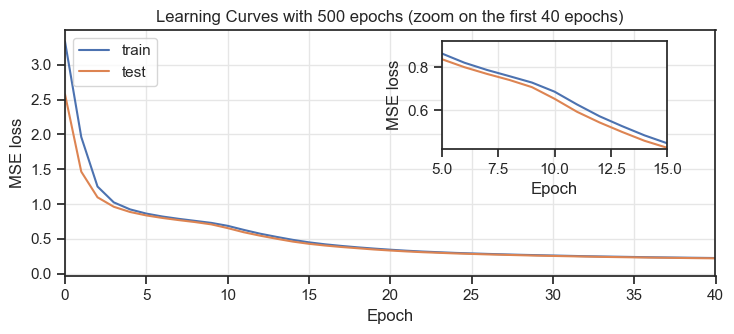

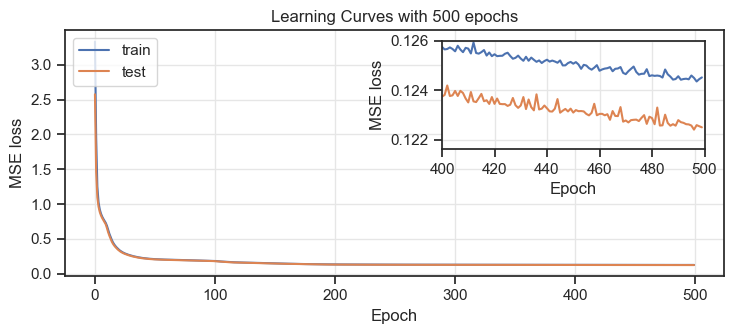

In [41]:
# plot learning curves
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
fig, ax1 = plt.subplots()
plt.title("Learning Curves with 500 epochs (zoom on the first 40 epochs)")
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
ax1.plot((history_q.history['loss']), label="train")
ax1.plot((history_q.history['val_loss']), label="test")
plt.grid(color='0.90')
plt.xlim(0,40)
l, b, h, w = .6, .55, .31, .30 # position: l and b; dimension: h-height and w-width
ax2 = fig.add_axes([l, b, w, h])
plt.ylim(0.42, 0.92)
plt.xlim(5,15)
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
ax2.plot((history_q.history['loss']))
ax2.plot((history_q.history['val_loss']))
ax1.legend(loc='upper left')
plt.grid(color='0.90')
plt.show()

fig, ax1 = plt.subplots()
plt.title("Learning Curves with 500 epochs")
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
ax1.plot((history_q.history['loss']), label="train")
ax1.plot((history_q.history['val_loss']), label="test")
plt.grid(color='0.90')
l, b, h, w = .6, .55, .31, .35 # position: l and b; dimension: h-height and w-width
ax2 = fig.add_axes([l, b, w, h])
plt.ylim(0.1216,0.126)
plt.xlim(400,500)
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
ax2.plot((history_q.history['loss']))
ax2.plot((history_q.history['val_loss']))
ax1.legend(loc='upper left')
plt.grid(color='0.90')
plt.show()


#### Comparison trends between the predicted Specific Humidity and the stored Specific Humidity inside the dataset

201/201 [==============================] - 1s 3ms/step


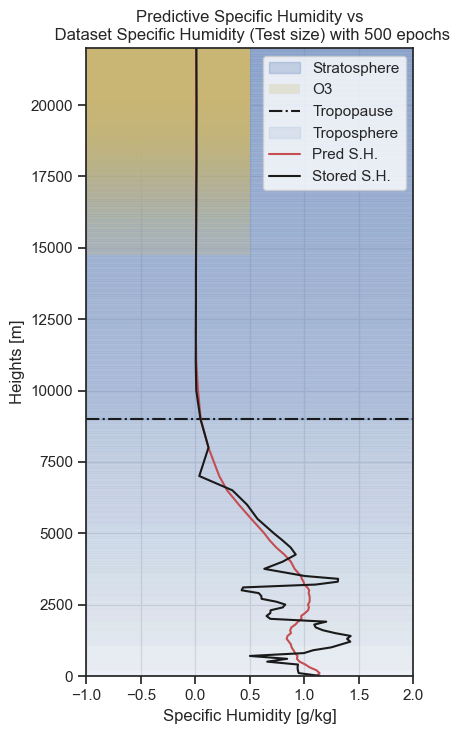

In [42]:
q_pred = model_q.predict(TB_test_scaled)
tropopause = 9000 # At 9 km at the poles, 17 km at the equator. Not an “hard” barrier, not so easy to define!
walk = 25
plt.rcParams["figure.figsize"] = [4.50, 7.50]
plt.rcParams["figure.autolayout"] = True

plt.title("Predictive Specific Humidity vs\n Dataset Specific Humidity (Test size) with 500 epochs")
# Stratosphere
plt.axhspan(tropopause, 23000, color="b", facecolor='0.8', alpha=0.25, label="Stratosphere")
for j in range(tropopause, 23000, walk):
    plt.axhspan(0+j, walk+j, color="b", facecolor='0.8', alpha=((j+1)/(6*23000)))
# O3    
plt.axvspan(-1, 0.5, 0.67, 1, facecolor='y', alpha=0.25, label="O3", lw=0)
for k in np.arange(0, 1, 0.01):
    plt.axvspan(-1, 0.5, 0.67+k, 1+k, facecolor='y', alpha=k, lw=0)
# Tropopause
plt.axhline(y=tropopause, color='k', linestyle='-.', label="Tropopause")
# Troposphere
plt.axhspan(0, tropopause, color='b',facecolor='0.9', alpha=0.1, label="Troposphere")
for i in range(0, tropopause, walk):
    plt.axhspan(0+i, walk+i, color='b',facecolor='0.9', alpha=i/(12*tropopause))
# Prediction Humidity vs Stored Humidity  
plt.plot(q_pred[0], heights, color='r', label='Pred S.H.')
plt.plot(q_test[0], heights, color='k', label='Stored S.H.')
plt.ylabel('Heights [m]')
plt.xlabel('Specific Humidity [g/kg]')
plt.ylim(0, 22000)
plt.xlim(-1,2)
plt.grid(color='0.90')
plt.legend()
plt.show()


## Recap of Plot Results

In the following code it can be seen the plots of:
- Temperature (in $K$) and Specific Humidity (in linear $g/kg$) predicted and stored respect heights (in $m$);
- Stored Pressure (in $hPa$) respect heights (in $m$);
- Temperature (in $K$) and Specific Humidity (in $log_{10}(g/kg)$) predicted and stored respect pressures (in $hPa$).

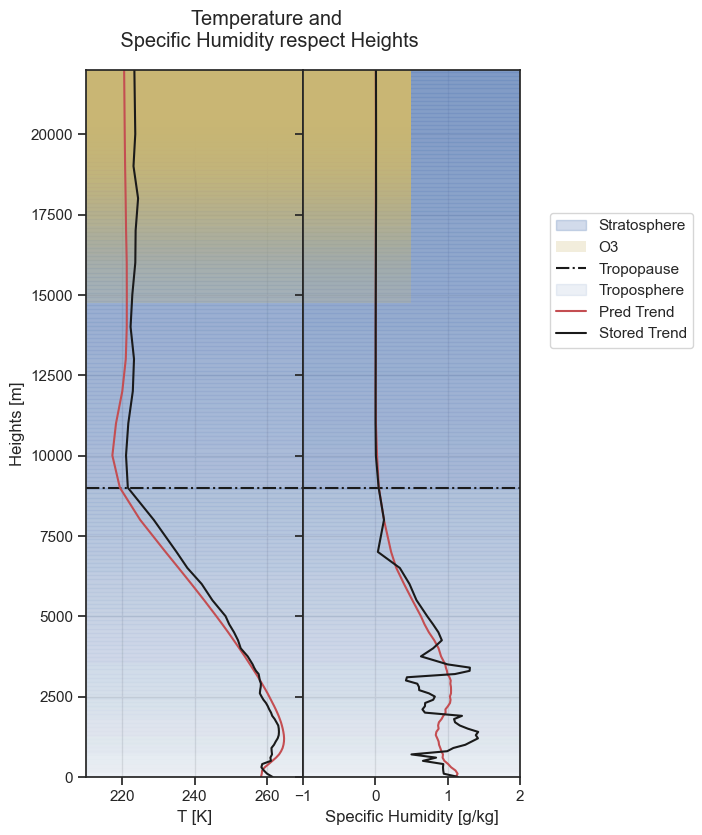

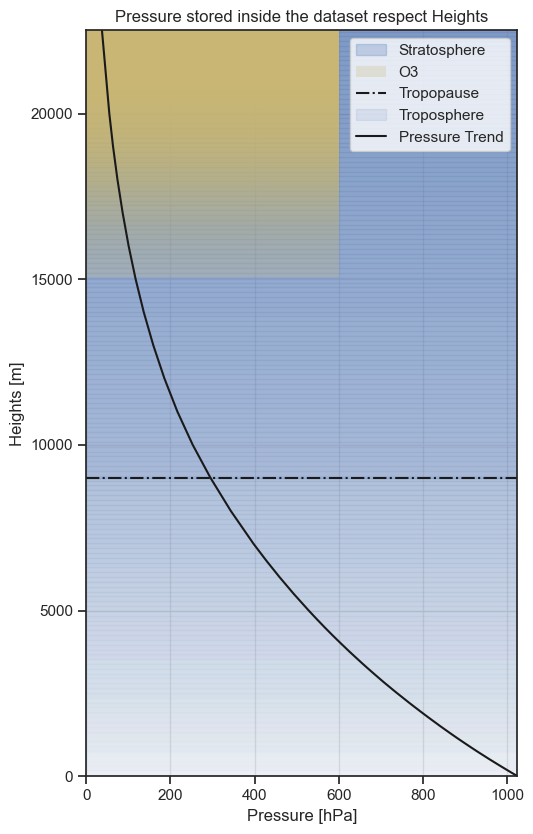

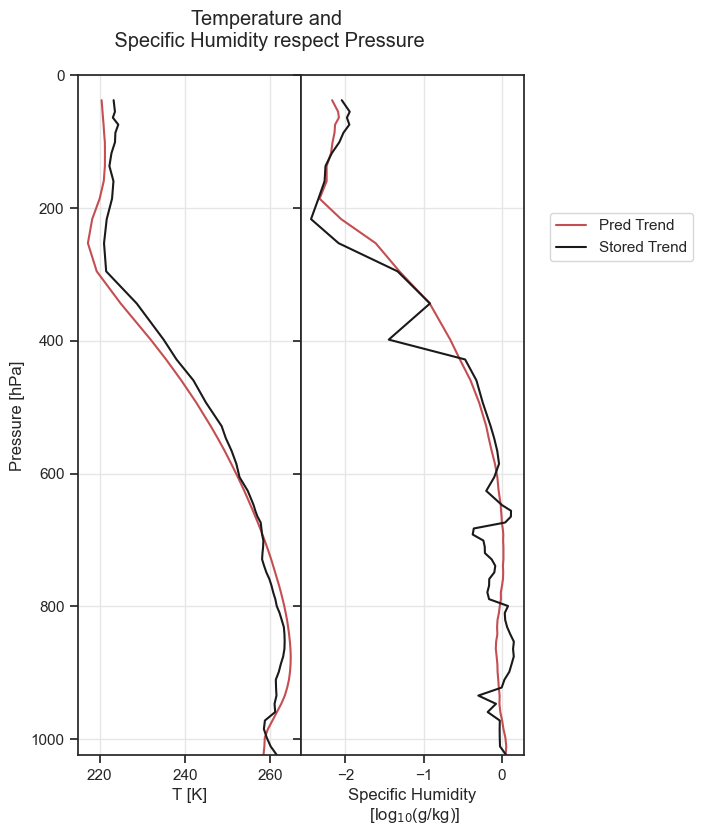

In [44]:
# Recap of Plot Results
tropopause = 9000 # At 9 km at the poles, 17 km at the equator. Not an “hard” barrier, not so easy to define!
walk = 25
plt.rcParams["figure.figsize"] = [5.50, 8.50]
plt.rcParams["figure.autolayout"] = True

# ################## plot respect height ##################

fig = plt.figure()
gs = fig.add_gridspec(1, 2, hspace=0, wspace=0)
(ax1, ax2) = gs.subplots(sharex='col', sharey='row')
fig.suptitle('Temperature and\n Specific Humidity respect Heights')

# SUBPLOT TEMPERATURE
# Stratosphere
ax1.axhspan(tropopause, 23000, color="b", facecolor='0.8', alpha=0.2)
for j in range(tropopause, 23000, walk):
    ax1.axhspan(0+j, walk+j, color="b", facecolor='0.8', alpha=((j+1)/(4*23000)))
# O3    
ax1.axvspan(210, 270, 0.67, 1, facecolor='y', alpha=0.25, lw=0)
for k in np.arange(0, 1, 0.01):
    ax1.axvspan(210, 270, 0.67+k, 1+k, facecolor='y', alpha=k, lw=0)
# Tropopause
ax1.axhline(y=tropopause, color='k', linestyle='-.')
# Troposphere
ax1.axhspan(0, tropopause, color='b',facecolor='0.9', alpha=0.1)
for i in range(0, tropopause, walk):
    ax1.axhspan(0+i, walk+i, color='b',facecolor='0.9', alpha=i/(8*tropopause))
# Prediction Temperature vs Stored Temperature    
ax1.plot(temp_pred_new[0], heights, color='r')
ax1.plot(temp_test[0], heights, color='k')
ax1.set_ylim(0, 22000)
ax1.set_xlim(210,270)
ax1.grid(color='0.90')
ax1.set(xlabel='T [K]', ylabel='Heights [m]')

# SUBPLOT SH
# Stratosphere
ax2.axhspan(tropopause, 23000, color="b", facecolor='0.8', alpha=0.25, label="Stratosphere")
for j in range(tropopause, 23000, walk):
    ax2.axhspan(0+j, walk+j, color="b", facecolor='0.8', alpha=((j+1)/(4*23000)))
# O3    
ax2.axvspan(-1, 0.5, 0.67, 1, facecolor='y', alpha=0.25, label="O3", lw=0)
for k in np.arange(0, 1, 0.01):
    ax2.axvspan(-1, 0.5, 0.67+k, 1+k, facecolor='y', alpha=k, lw=0)
# Tropopause
ax2.axhline(y=tropopause, color='k', linestyle='-.', label="Tropopause")
# Troposphere
ax2.axhspan(0, tropopause, color='b',facecolor='0.9', alpha=0.1, label="Troposphere")
for i in range(0, tropopause, walk):
    ax2.axhspan(0+i, walk+i, color='b',facecolor='0.9', alpha=i/(8*tropopause))
# Prediction Humidity vs Stored Humidity  
ax2.plot(q_pred[0], heights, color='r', label='Pred Trend')
ax2.plot(q_test[0], heights, color='k', label='Stored Trend')
ax2.set_ylim(0, 22000)
ax2.set_xlim(-1,2)
ax2.grid(color='0.90')
ax2.set(xlabel='Specific Humidity [g/kg]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in fig.get_axes():
    ax.label_outer()
    
fig.legend(loc="upper left",  bbox_to_anchor=[1, 0.75])

plt.show()

# ################## plot respect pressure ##################
# plot of stored Pressure Trend respect Heights
plt.title("Pressure stored inside the dataset respect Heights")

# Stratosphere
plt.axhspan(tropopause, 23000, color="b", facecolor='0.8', alpha=0.25, label="Stratosphere")
for j in range(tropopause, 23000, walk):
    plt.axhspan(0+j, walk+j, color="b", facecolor='0.8', alpha=((j+1)/(4*23000)))
# O3    
plt.axvspan(0, 600, 0.67, 1, facecolor='y', alpha=0.25, label="O3", lw=0)
for k in np.arange(0, 1, 0.01):
    plt.axvspan(0, 600, 0.67+k, 1+k, facecolor='y', alpha=k, lw=0)
# Tropopause
plt.axhline(y=tropopause, color='k', linestyle='-.', label="Tropopause")
# Troposphere
plt.axhspan(0, tropopause, color='b',facecolor='0.9', alpha=0.1, label="Troposphere")
for i in range(0, tropopause, walk):
    plt.axhspan(0+i, walk+i, color='b',facecolor='0.9', alpha=i/(8*tropopause))
plt.plot(bar_test[0]/100, heights, color="k", label="Pressure Trend")
plt.grid(color='0.90')
plt.xlabel("Pressure [hPa]")
plt.ylabel("Heights [m]")
plt.ylim(0, max(heights))
plt.xlim(0, max(bar_test[0]/100))
plt.legend(loc="upper right")
plt.show()

# subplot of temperature and SH respect pressure
fig = plt.figure()
gs = fig.add_gridspec(1, 2, hspace=0, wspace=0)
(ax1, ax2) = gs.subplots(sharex='col', sharey='row')
fig.suptitle('Temperature and\n Specific Humidity respect Pressure')

# SUBPLOT TEMPERATURE
# Prediction Temperature vs Stored Temperature  
ax1.plot(temp_pred_new[0], bar_test[0]/100, color='r')
ax1.plot(temp_test[0], bar_test[0]/100, color='k')
ax1.grid(color='0.90')
ax1.set(xlabel='T [K]', ylabel='Pressure [hPa]')

# SUBPLOT SH
# Prediction Humidity vs Stored Humidity 
ax2.plot(np.log10(q_pred[0]), bar_test[0]/100, color='r', label='Pred Trend')
ax2.plot(np.log10(q_test[0]), bar_test[0]/100, color='k', label='Stored Trend')
ax2.grid(color='0.90')
ax2.set_xlabel('Specific Humidity\n [log$_{10}$(g/kg)]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in fig.get_axes():
    ax.label_outer()
    
fig.legend(loc="upper left",  bbox_to_anchor=[1, 0.75])

# plt.ylim(max(bar_test[0]), min(bar_test[0]))
plt.ylim(max(bar_test[0]/100), 0)

plt.show()


## 5th point
Compare the results in sounding T and q with the test profiles, when applying the Optimal Estimation algorithm of lab06 and the neural network trained in 4. Comment the differences between the results with the two approaches.

### Microwave Radiometer Temperature and Humidity Retrieval - Optimal Estimation algorithm

*[From lab06]*

In the following, we introduce the use of the pyOptimalEstimation Python library using a standard temperature
and humidity retrieval for a microwave radiometer (MWR, Rose et al 2005). We use the simple forward operator
introduced by Löhnert et al. (2004) which does not account for scattering by hydrometeors. The prior is
estimated based on 16 years of spring (March - May) radiosonde observations at the U.S. Department of Energy
Atmospheric Radiation Measurement (ARM) program at the North Slope of Alaska (NSA) site in Utqiagvik (Barrow),
Alaska. See the `prepare_radiosondes.ipynb` script in `lib` for details.


### Load dataset

It's the <code>prior</code> dataset but I called it <code>prior_ope</code> (ope = optimal estimation) to not update the <code>prior</code> dataset variable used at the beginning of this project. Just to repeat, the unit of measurement for temperature is the Kelvin, specific humidity is given in g/kg and pressure is in Pa.

In [45]:
sys.path.append('lib')
import nonScatMWRadTran # error if is not runned on optim3 environment (numba packege is missed)
import supporting_routines

prior_ope = xr.open_dataset('data/radiosonde_climatology_nsa_2002-2020.nc')
prior_ope

<xarray.Dataset>
Dimensions:   (time: 24095, height: 60)
Coordinates:
  * time      (time) datetime64[ns] 2002-04-29 ... 2020-02-04T18:00:00
  * height    (height) float32 8.0 108.0 208.0 ... 1.901e+04 2.001e+04 2.251e+04
Data variables:
    temp      (time, height) float32 ...
    q         (time, height) float32 ...
    bar_pres  (time, height) float32 ...

**Optimal Estimation requires that the distribution of the prior data is following a normal distribution.** We use *Quantile-quantile (QQ) plots* to evaluate whether this condition is fulfilled for temperature and humidity using both linear (left) and logarithmic (right). Normal distributions are located on the red line and have a higher $R^2$ value

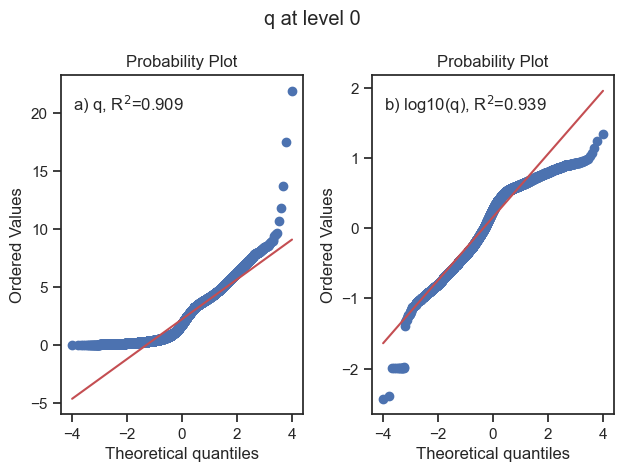

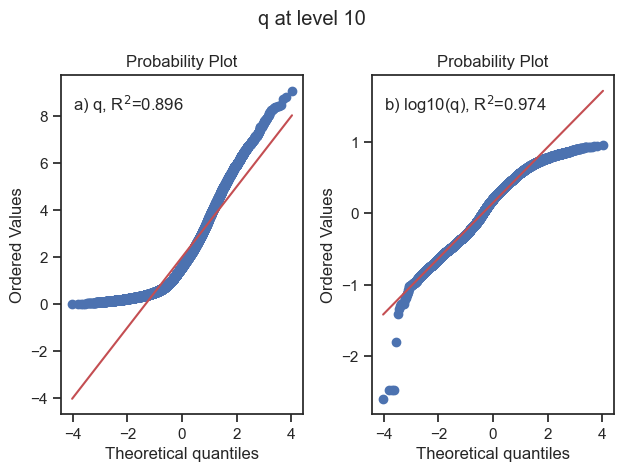

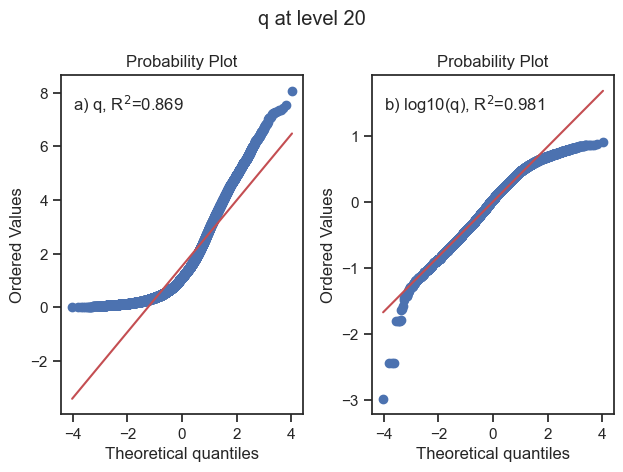

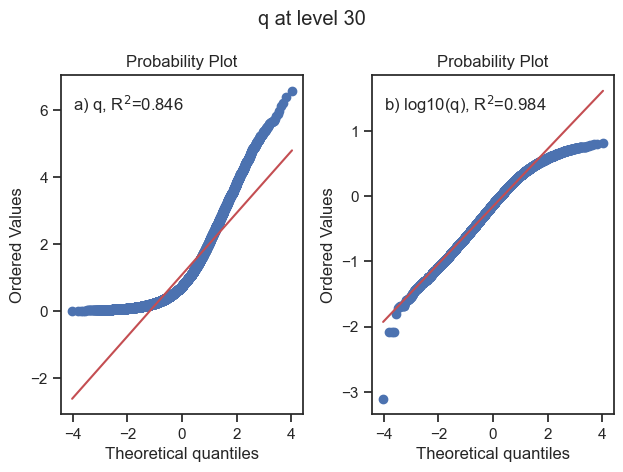

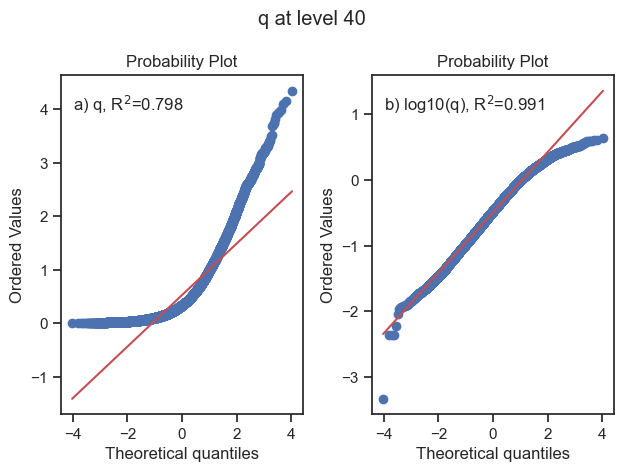

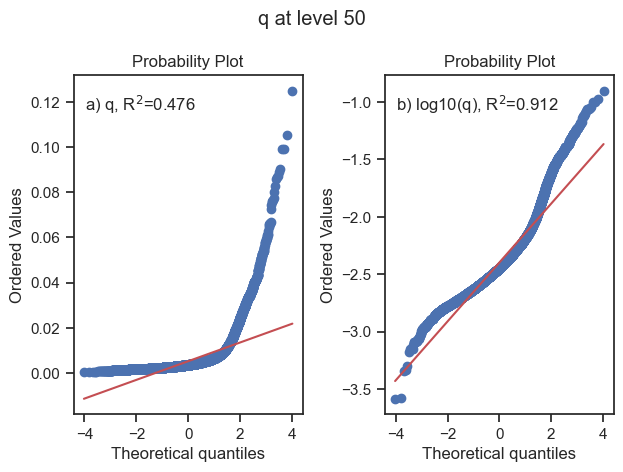

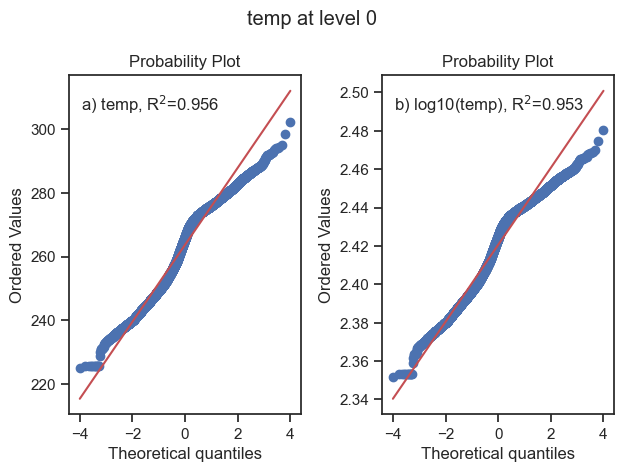

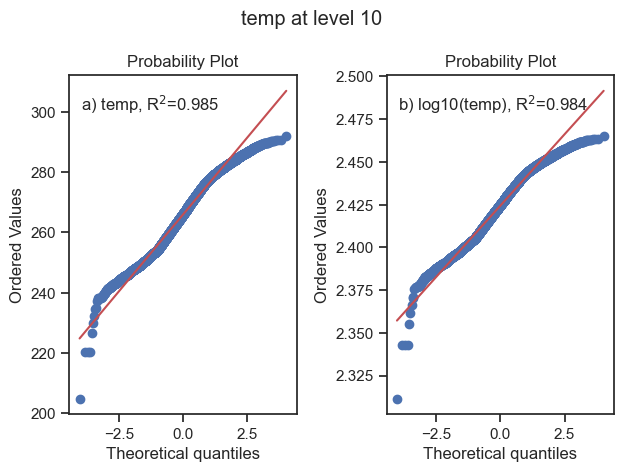

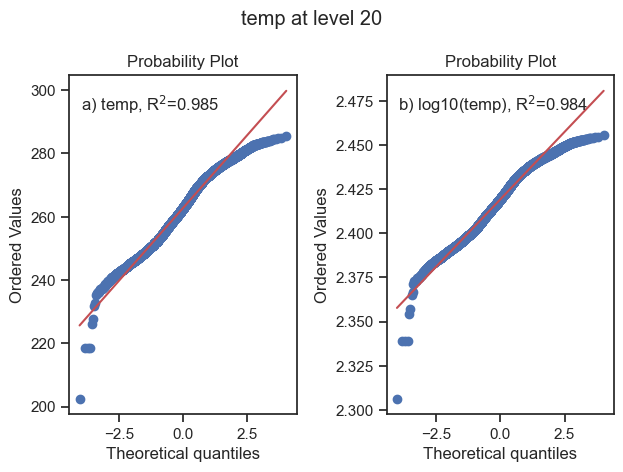

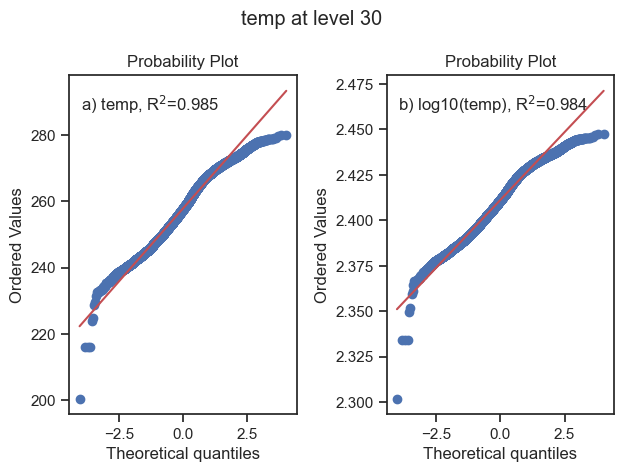

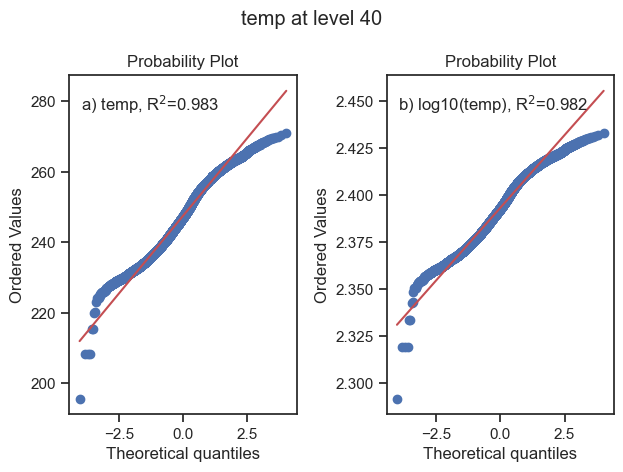

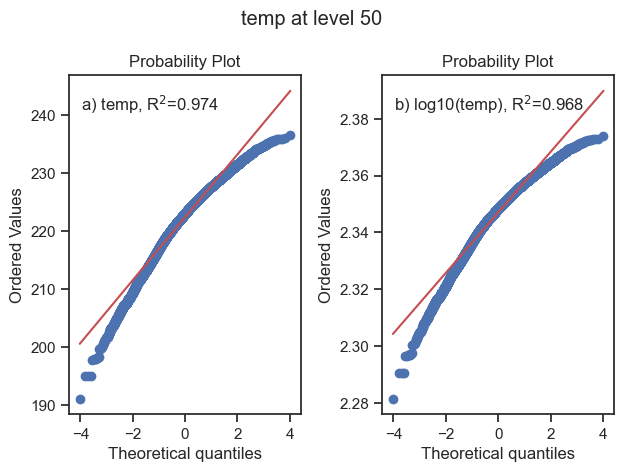

In [46]:
plt.rcParams["figure.figsize"] = [6.4, 4.8] # default sizes (in inches) [width, height]
# plt.rcParams["figure.autolayout"] = True

for var in ['q', 'temp']:
    for h in range(0, 60, 10):
        fig, (ax, ax1) = plt.subplots(ncols=2)
        plt.suptitle('%s at level %i' % (var,h))
        (osm, osr), (slope, intercept, r) = stats.probplot(
            prior_ope[var].isel(height=h).dropna('time').values,
            dist="norm",
            plot=ax,
            fit=True,
            rvalue=False)
        ax.text(
            0.05,
            0.95,
            '%s) %s, R$^2$=%.3g' % ('a', var, r**2),
            horizontalalignment='left',
            verticalalignment='top',
            transform=ax.transAxes)

        (osm, osr), (slope, intercept, r) = stats.probplot(
            np.log10(prior_ope[var].isel(height=h).dropna('time').values),
            dist="norm",
            plot=ax1,
            fit=True,
            rvalue=False)
        ax1.text(
            0.05,
            0.95,
            '%s) %s, R$^2$=%.3g' % ('b', 'log10(%s)'%var, r**2),
            horizontalalignment='left',
            verticalalignment='top',
            transform=ax1.transAxes)
        fig.tight_layout()

For humidity, it can be seen that the distribution is more normal when using logarithmic units. Using logarithmic units makes also sure that the retrieval cannot converge to non-physical negative values. For temperature, instead, there is no benefit in using a logarithmic distribution and we stick with using temperature in linear units.

In [47]:
prior_ope['q'] = np.log10(prior_ope['q'])
print(prior_ope.q.values)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



We select sample profiles and **remove them from the prior data**. We will use them to
estimate synthetic observations. By this, we can evaluate the retrieval result by comparison with the true
atmospheric state and we are not impacted by potential forward operator biases.

In [48]:
profileTT = np.array([
    '2004-03-16T12:00:00.000000000', '2006-04-01T00:00:00.000000000',
    '2009-01-30T18:00:00.000000000', '2014-07-27T06:00:00.000000000',
    '2018-01-08T12:00:00.000000000'
],dtype='datetime64[ns]')

# from prior dataset i select time values correlated with profileTT to eliminate missing data
profiles = prior_ope.sel(time=profileTT) # storage of 5 profiles on 24090 profiles
prior_ope = prior_ope.drop_sel(time=profileTT) # update of the dataset
nLev = len(prior_ope.height) # length of height that are 60 heights

We want to estimate the prior for all four seasons separately, so we split the data set up by season

In [49]:
priors = {'all': prior_ope}

seasons = [
    'DJF',
    'MAM',
    'JJA',
    'SON',
]
months = (
    [12, 1, 2],
    [3, 4, 5],
    [6, 7, 8],
    [9, 10, 11],
)
for season, month in zip(seasons, months):
    priors[season] = prior_ope.where(
        np.in1d(prior_ope['time.month'], month)[:, np.newaxis]).dropna(
            'time', how='all')

In preparation for estimating the covariance matrix, we create a pandas DataFrame of dimension _time x state-variable_. pandas (`pn`) `Series` and `DataFrame` objects  are basically annotated arrays. This makes keeping track of the various elements of $\mathbf{x}$ and $\mathbf{y}$ easier.

We need names for our $\mathbf{x}$ variables to avoid any confusion. Therefore, we use a string containing the **height in meters** and the variable name **(t or q)**. E.g., **'00008_q'** is **humidity at 8 m altitude**.

In [50]:
prior_qts = {}
for season in priors.keys():
    prior_q = priors[season]['q'].to_pandas()
    prior_q.columns = ['%05i_q' % (i) for i in prior_q.columns]
    prior_t = priors[season]['temp'].to_pandas()
    prior_t.columns = ['%05i_t' % (i) for i in prior_t.columns]
    prior_qts[season] = pn.concat((prior_q, prior_t), axis=1)
    prior_qts[season] = prior_qts[season].reindex(
        sorted(prior_qts[season].columns), axis=1)

prior_qts

{'all':                       00008_q     00008_t   00107_q     00107_t   00207_q  \
 time                                                                        
 2002-04-29 00:00:00  0.064744  261.699982  0.120490  262.639984  0.121120   
 2002-04-29 06:00:00  0.026484  260.470001  0.111891  261.729980  0.115678   
 2002-04-29 12:00:00 -0.012288  259.239990  0.032706  259.380005  0.046552   
 2002-04-29 18:00:00 -0.051580  258.009979 -0.048208  257.019989 -0.023759   
 2002-04-30 00:00:00  0.058703  261.549988 -0.023267  260.049988 -0.026649   
 ...                       ...         ...       ...         ...       ...   
 2020-02-03 18:00:00 -0.976898  235.709991 -0.543270  243.750000 -0.534117   
 2020-02-04 00:00:00 -0.950991  236.199997 -0.545425  244.479996 -0.501717   
 2020-02-04 06:00:00 -1.003483  235.179993 -0.464527  245.580002 -0.454255   
 2020-02-04 12:00:00 -0.714312  241.269989 -0.544978  244.059998 -0.492173   
 2020-02-04 18:00:00 -0.819013  238.909988 -0.580955  242

Now, we can estimate the mean $\mathbf{x}_{a}$ and covariance **S**$_a$ of the prior easily and combine them for all seasons:

In [51]:
x_cov = []
x_mean = []

for season in ['all'] + seasons:

    x_cov1 = prior_qts[season].cov().rename_axis('state', axis=0).rename_axis('stateT', axis=1)
    x_mean1 = prior_qts[season].mean().rename_axis('state', axis=0)

    x_cov.append(xr.DataArray(x_cov1))
    x_mean.append(xr.DataArray(x_mean1))

x_cov = xr.concat(x_cov, dim='season')
x_mean = xr.concat(x_mean, dim='season')

x_cov['season'] = ['all'] + seasons
x_mean['season'] = ['all'] + seasons

It is crucial that the covariance matrix can be inverted (i.e. is not singular) which we test with calculating the rank

In [52]:
for season in x_cov.season:
    assert np.linalg.matrix_rank(x_cov.sel(season=season).to_pandas()) ==  x_cov.shape[-1]

The resulting mean profiles are plotted for every season

Text(0, 0.5, 'Height [m]')

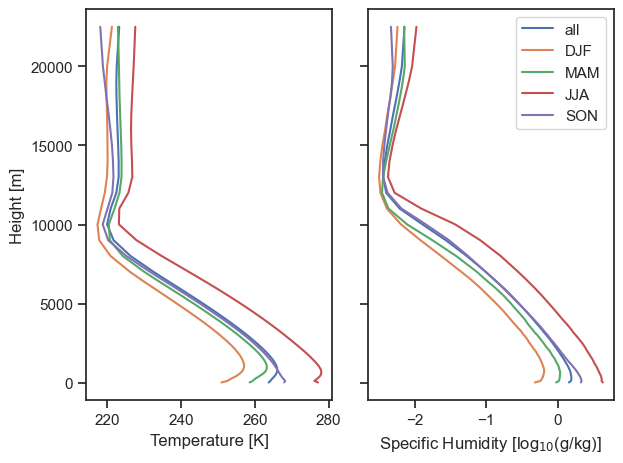

In [53]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
for season in ['all'] + seasons:
    t, q = supporting_routines.splitTQ(x_mean.sel(season=season).to_pandas())
    ax1.plot(t, t.index, label=season)
    ax2.plot(q, q.index, label=season)

ax2.legend()
ax1.set_xlabel('Temperature [K]')
ax2.set_xlabel('Specific Humidity [log$_{10}$(g/kg)]')
ax1.set_ylabel('Height [m]')

We plot the spring covariance matrix. Note how the Tropopause can be clearly seen around 10 km. For convenience, we show the covariance matrix separately for T and q even though we consider correlations between T and q.

Text(0.5, 1.0, '$\\mathbb{S}_{a}$ Humidity')

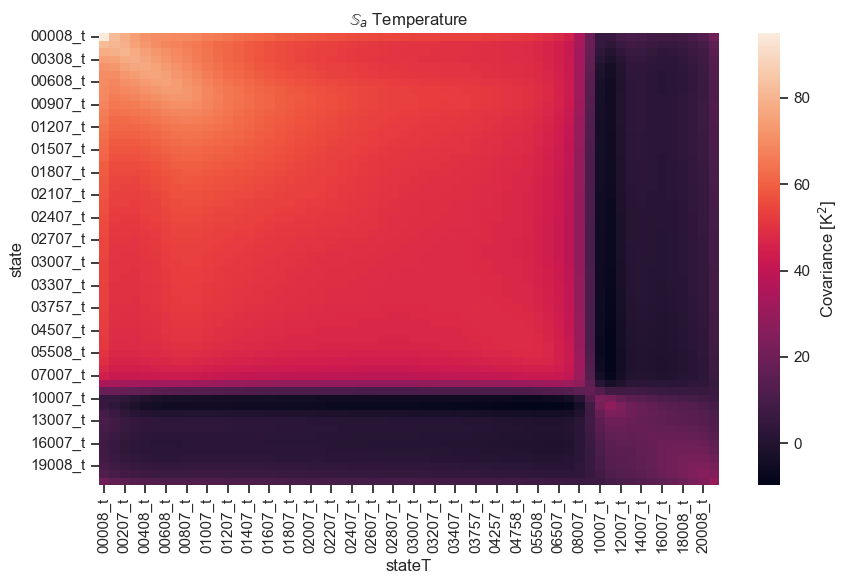

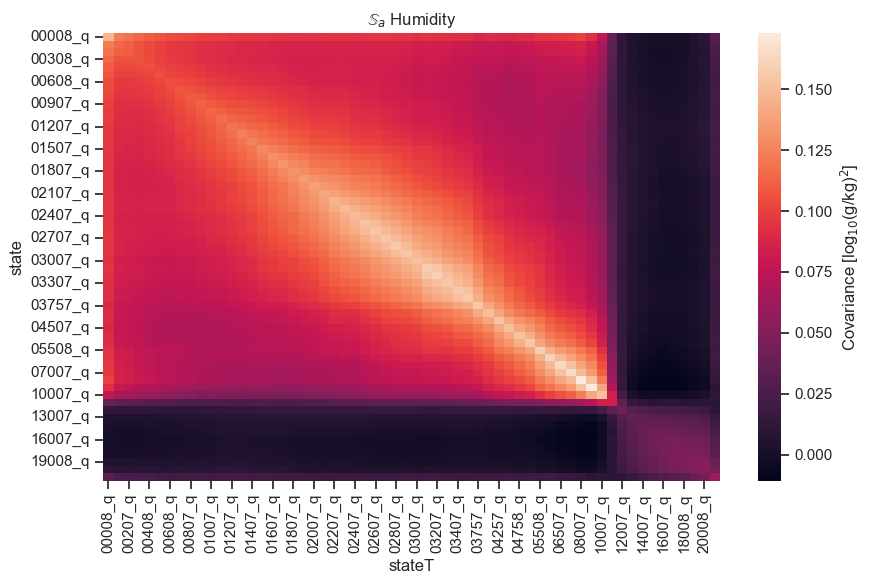

In [54]:
S_a = x_cov.sel(season='MAM').to_pandas()
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(S_a.iloc[1::2, 1::2], ax=ax, cbar_kws={'label':'Covariance [K$^2$]'})
ax.set_title('$\mathbb{S}_{a}$ Temperature')
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(S_a.iloc[::2, ::2], ax=ax, cbar_kws={'label':'Covariance [log$_{10}$(g/kg)$^2$]'})
ax.set_title('$\mathbb{S}_{a}$ Humidity')

As supporting information, we also need the height levels and mean pressure profiles for every season wich we also estimate form the radiosonde data set

In [55]:
height = priors['all'].height

pressure = []
for k in ['all'] + seasons:
    pressure.append(priors[k].bar_pres.mean('time'))
pressure = xr.concat(pressure, dim='season')
pressure['season'] = ['all'] + seasons
pressure = pressure.to_pandas()
pressure

height,8.000000,107.999992,207.999969,308.000000,408.000061,508.000061,608.000000,707.999878,807.999817,907.999695,...,12007.995117,13007.994141,14007.993164,15007.992188,16007.992188,17007.996094,18008.000000,19008.003906,20008.007812,22508.007812
season,,,,,,,,,,,,,,,,,,,,,
all,101411.312500,100181.101562,98893.625000,97624.539062,96374.359375,95141.609375,93925.835938,92726.820312,91542.953125,90375.398438,...,18318.185547,15714.389648,13483.758789,11570.416016,9927.844727,8520.158203,7313.539062,6281.495117,5406.569336,3732.111816
DJF,101641.226562,100320.007812,98973.242188,97648.664062,96346.171875,95064.554688,93802.890625,92560.343750,91336.171875,90128.703125,...,17581.072266,15046.706055,12882.336914,11032.179688,9446.294922,8092.613281,6931.801270,5942.553223,5098.184082,3472.734375
MAM,101837.007812,100520.359375,99206.117188,97911.289062,96636.718750,95382.406250,94146.843750,92930.109375,91730.562500,90547.296875,...,18171.298828,15596.017578,13388.307617,11491.730469,9864.220703,8466.375000,7266.686523,6237.169434,5357.356445,3669.576660
JJA,101238.234375,100016.382812,98790.179688,97582.039062,96390.351562,95214.554688,94054.148438,92907.414062,91774.906250,90655.531250,...,19332.447266,16622.179688,14297.146484,12295.776367,10573.527344,9092.315430,7819.685059,6726.113770,5785.992188,3974.533936
SON,100919.210938,99874.992188,98610.507812,97361.195312,96125.789062,94904.742188,93697.679688,92504.898438,91326.265625,90161.148438,...,18158.330078,15562.971680,13339.403320,11432.937500,9795.538086,8390.832031,7187.949219,6156.890137,5280.847168,3598.150879


Finally, we convert the profiles (which we saved before to a Pandas Object) so that can be understood by the forward operator 

In [56]:
profiles_t = profiles['temp'].to_pandas()
profiles_t.columns = ['%05i_t' % (i) for i in profiles_t.columns]
profiles_q = profiles['q'].to_pandas()
profiles_q.columns = ['%05i_q' % (i) for i in profiles_q.columns]

x_truths = pn.concat((profiles_t, profiles_q), 1)
x_truths = x_truths.reindex(sorted(x_truths.index), axis=0)
x_truths.columns.name = 'state'
x_truths.index.name = 'time'

assert np.all(np.isfinite(x_truths))
x_truths

state,00008_t,00107_t,00207_t,00308_t,00408_t,00508_t,00608_t,00707_t,00807_t,00907_t,...,12007_q,13007_q,14007_q,15007_q,16007_q,17007_q,18008_q,19008_q,20008_q,22508_q
time,,,,,,,,,,,,,,,,,,,,,
2004-03-16 12:00:00,248.269989,247.599991,250.889999,255.429993,258.699982,259.540009,259.109985,258.269989,257.459991,257.419983,...,-2.426702,-2.368711,-2.282595,-2.202477,-2.004690,-1.974985,-1.926023,-1.940949,-1.882235,-1.898666
2006-04-01 00:00:00,248.000000,247.239990,248.899994,251.239990,252.149994,252.819992,253.209991,253.449997,253.789993,254.509995,...,-2.158761,-2.095802,-2.306196,-2.145840,-2.194748,-2.208211,-2.195101,-2.226646,-2.278249,-2.412320
2009-01-30 18:00:00,251.729996,252.099991,254.119995,254.549988,254.549988,254.470001,254.339996,254.019989,253.879990,254.849991,...,-2.191924,-2.081939,-1.937669,-1.830115,-1.767967,-1.657959,-1.653461,-1.603367,-1.668807,-1.926275
2014-07-27 06:00:00,273.160004,271.679993,270.929993,270.350006,272.169983,273.100006,273.019989,272.919983,272.639984,272.540009,...,-2.533212,-2.516264,-2.474560,-2.435602,-2.375896,-2.302611,-2.242050,-2.217488,-2.161998,-1.946173
2018-01-08 12:00:00,248.839996,249.189987,250.159988,255.939987,257.470001,257.929993,258.100006,258.989990,259.389984,259.729980,...,-2.417694,-2.748187,-2.735237,-2.792282,-2.786179,-2.804525,-2.798916,-2.774575,-2.739619,-2.649273


### Define forward operator

Next, we define the forward operator. pyOptimalEstimation requires that the state vector $\mathbf{x}$ is the first argument of the forward operator function and the measurement vector $\mathbf{y}$ is returned. All the magic is handled by the nonScatMWRadTran library (Löhnert et al. 2004), the function `forwardRT` defined below is for converting it to the correct SI units.

In [57]:
def forwardRT(X, pressure=None, zenithAngle=0, frequencies=[]):

    # X contains T and Q, lets split the vector
    temperature, humidity = supporting_routines.splitTQ(X)
    # humdity is in log10 scale, convert to linear in kg/kg
    humidity = (10**humidity) / 1000.
    # Height in meters comes from index of the temperature (or humidty) vector
    heights = temperature.index
    assert np.all(np.diff(heights) > 0)

    # get absolute humidty from specific humdity
    abs_humidity = supporting_routines.q2a(humidity, pressure, temperature)
    
    # run the forward operator
    TB, tau, tau_wv, tau_o2 = nonScatMWRadTran.STP_IM10(
        heights,  # [m]  
        temperature,  # [K]
        pressure,  # [Pa]
        abs_humidity,  # [kgm^-3]
        zenithAngle,  # zenith angle of observation in deg.
        frequencies,  # frequency vector in GHz
    )
    return TB

See the file `lib/nonScatMWRadTran.py` for the actual forward operator code which is in detail described in Löhnert et al. (2004).

### Run reference retrieval
We start with the retrieval configuration we will call the *reference run* in the following.

We use the standard frequencies in GHz of an HATPRO microwave radiometer (Rose et al 2005), same frequencies used at the beginning of the project. We need names for our $\mathbf{y}$ and $\mathbf{x}$ variables to avoid any confusion. For $\mathbf{y}$, we select the frequencies, for $\mathbf{x}$ we use a string containing the height in meters and the variable names defined above

In [58]:
frequencies = Frequencies
y_vars = np.array(frequencies)
x_vars = x_mean.state.values
print('y_vars:\n', y_vars)
print('x_vars:\n', x_vars)

y_vars:
 [22.24 23.04 23.84 25.44 26.24 27.84 31.4  51.26 52.28 53.86 54.94 56.66
 57.3  58.  ]
x_vars:
 ['00008_q' '00008_t' '00107_q' '00107_t' '00207_q' '00207_t' '00308_q'
 '00308_t' '00408_q' '00408_t' '00508_q' '00508_t' '00608_q' '00608_t'
 '00707_q' '00707_t' '00807_q' '00807_t' '00907_q' '00907_t' '01007_q'
 '01007_t' '01107_q' '01107_t' '01207_q' '01207_t' '01307_q' '01307_t'
 '01407_q' '01407_t' '01507_q' '01507_t' '01607_q' '01607_t' '01707_q'
 '01707_t' '01807_q' '01807_t' '01907_q' '01907_t' '02007_q' '02007_t'
 '02107_q' '02107_t' '02207_q' '02207_t' '02307_q' '02307_t' '02407_q'
 '02407_t' '02507_q' '02507_t' '02607_q' '02607_t' '02707_q' '02707_t'
 '02807_q' '02807_t' '02907_q' '02907_t' '03007_q' '03007_t' '03107_q'
 '03107_t' '03207_q' '03207_t' '03307_q' '03307_t' '03407_q' '03407_t'
 '03507_q' '03507_t' '03757_q' '03757_t' '04007_q' '04007_t' '04257_q'
 '04257_t' '04507_q' '04507_t' '04758_q' '04758_t' '05008_q' '05008_t'
 '05508_q' '05508_t' '06008_q' '06008_t' '0

### Prepare retrieval

For this example we use the atmospheric profile at Barrow at 2006-04-01T00:00:00 which we call $\mathbf{x}_{truth}$ in the following

In [59]:
season = 'MAM'  #Spring: March April May
profile = np.datetime64('2006-04-01T00:00:00')
x_truth = x_truths.loc[profile]
x_truth

state
00008_t    248.000000
00107_t    247.239990
00207_t    248.899994
00308_t    251.239990
00408_t    252.149994
              ...    
17007_q     -2.208211
18008_q     -2.195101
19008_q     -2.226646
20008_q     -2.278249
22508_q     -2.412320
Name: 2006-04-01 00:00:00, Length: 120, dtype: float32

The measurement uncertainty is expressed as a covariance matrix (**S**$_y$) which have been determined by continuously measuring the brightness temperatures of a black body with a known temperature.  For now, we assume that covariances between the channels can be neglected, i.e. **S**$_y$ is a diagonal matrix. Describing measurement uncertainties (and the prior) with a covariance matrix implies that the variability can be described with a normal distribution.


In [60]:
y_error_std = pn.Series(
    [
        0.12026637, 0.10864162, 0.10412012, 0.0918477, 0.10174478, 0.10085633,
        0.10500476, 0.42303663, 0.45658514, 0.26291823, 0.25538793, 0.1773584,
        0.17556195, 0.59489495
    ],
    index=y_vars
)

S_y = pn.DataFrame(
    np.diag(y_error_std.values**2),
    index=y_vars,
    columns=y_vars,
)


**S**$_y$ is visualized with:

Text(0.5, 1.0, 'Measurement uncertainty $\\mathbf{S}_{y}$')

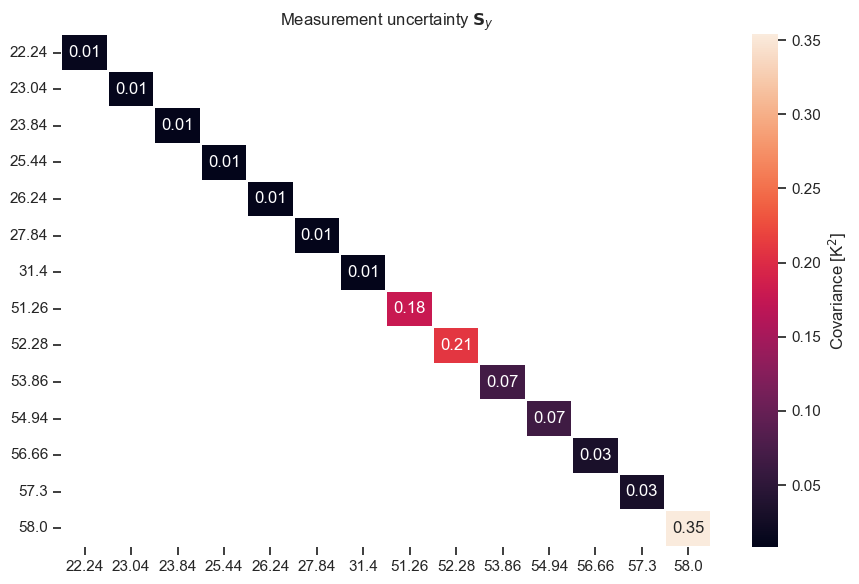

In [61]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(
    S_y.where(S_y > 0), 
    annot=True, 
    fmt='.2f', 
    ax=ax, 
    linewidths=.05, 
    cbar_kws={'label':'Covariance [K$^2$]'}
)
ax.set_title(r'Measurement uncertainty $\mathbf{S}_{y}$')


The prior **S**$_a$ is obtained from the mean and covariance matrix provided in the netCDF file loaded above. 

In [62]:
x_a = x_mean.sel(season='MAM').to_pandas()[x_vars]
S_a = x_cov.sel(season='MAM').to_pandas().loc[x_vars, x_vars]

It is crucial that **S**$_a$ and **S**$_y$ can be inverted. When using different units in $\mathbf{x}$ and/or $\mathbf{y}$ and mixing very small and large values, the inversion might fail for numerical reasons. In this case we recommend to experiment with different units.

Note: Numpy's `np.linalg.inv` does not always catch singular matrices as shown below:

In [63]:
singularMatrix = np.array([[1,0,0], [1,0,1e-50], [1,1e-50,0]])
np.linalg.inv(singularMatrix)

array([[ 1.e+00,  0.e+00,  0.e+00],
       [-1.e+50,  0.e+00,  1.e+50],
       [-1.e+50,  1.e+50,  0.e+00]])

Therefore, it is recommended to use pyOptimalEstimation's `pyOE.invertMatrix` function which checks for matrix singularity. (The `try` and `except` is only to make sure the Notebook does not stop after the error is raised)

In [64]:
try:
    pyOE.invertMatrix(singularMatrix)
except Exception as err:
    traceback.print_tb(err.__traceback__)

  File "C:\Users\Davide\AppData\Local\Temp\ipykernel_5752\384370707.py", line 2, in <module>
    pyOE.invertMatrix(singularMatrix)
  File "C:\Users\Davide\anaconda3\envs\tf\lib\site-packages\pyOptimalEstimation\pyOEcore.py", line 1485, in invertMatrix
    raise ValueError("Found singular matrix", UserWarning)


Based on the true profile, we create a synthetic observation. Auxiliary data which needs to be passed on to the `forwardRT` function is stored in the `forwardKwArgs` dictionary. The `**forwardKwArgs` passes all dictionary values of `forwardKwArgs` as named function arguments (see https://www.geeksforgeeks.org/args-kwargs-python/).

In [65]:
forwardKwArgs = dict(
    pressure=pressure.loc['MAM'].values,
    zenithAngle=0,
    frequencies=frequencies
)

y_obs = forwardRT(x_truth, **forwardKwArgs)
y_obs = pn.Series(y_obs, index=y_vars)
assert np.all(np.isfinite(y_obs))

The resulting brightness temperatures are storted in  $\mathbf{y}_{obs}$ (`y_obs`)

In [66]:
y_obs

22.24     14.466894
23.04     13.997798
23.84     12.696146
25.44     11.040978
26.24     10.734442
27.84     10.689742
31.40     11.942638
51.26    105.147974
52.28    143.741944
53.86    230.379525
54.94    251.512077
56.66    250.604009
57.30    250.073282
58.00    249.693972
dtype: float64

`pyOptimalEstimation` uses objects. Therefore, we combine all information for the reference run into an object which we name `oe_ref` 

In [67]:
oe_ref = pyOE.optimalEstimation(
    x_vars, # state variable names
    x_a,  # a priori
    S_a, # a priori uncertainty
    y_vars,  # measurement variable names
    y_obs, # observations
    S_y, # observation uncertainty
    forwardRT, # forward Operator
    forwardKwArgs=forwardKwArgs, # additonal function arguments
    x_truth=x_truth, # true profile
)

Note that $\mathbf{x}_{truth}$ is only added to the `pyOE` object for convenience, it is not used to find a solution.

### Run retrieval
We are finally ready to run the retrieval. 

In [68]:
oe_ref.doRetrieval()

1.76 s, iteration 1, degrees of freedom: 4.70 of 120, not converged (x-space):  938.423
2.55 s, iteration 2, degrees of freedom: 4.67 of 120, not converged (x-space):  23.517
3.32 s, iteration 3, degrees of freedom: 4.67 of 120, converged (x-space):  0.118
4.06 s, iteration 4, degrees of freedom: 4.67 of 120, done.  0.000


True

As can be seen from the output, convergence is reached at the third iteration. After convergence, the solution $\mathbf{x}_{op}$ and the retrieved uncertainty **S**$_{op}$ is available with (only the first 10 elements are shown)

In [69]:
print(oe_ref.x_op[:10])
print(oe_ref.S_op[:10])

00008_q     -0.396555
00008_t    249.191496
00107_q     -0.376150
00107_t    248.462184
00207_q     -0.360388
00207_t    248.236036
00308_q     -0.340507
00308_t    249.167029
00408_q     -0.327820
00408_t    250.381067
dtype: float64
          00008_q   00008_t   00107_q   00107_t   00207_q   00207_t   00308_q  \
00008_q  0.015584  0.372022  0.002714 -0.000578  0.001970 -0.096688  0.002094   
00008_t  0.372022  9.474031  0.050433 -0.040050  0.034357 -2.414092  0.039127   
00107_q  0.002714  0.050433  0.005088  0.049410  0.004548 -0.001782  0.003777   
00107_t -0.000578 -0.040050  0.049410  1.512931  0.028072  0.400961  0.013133   
00207_q  0.001970  0.034357  0.004548  0.028072  0.006716  0.006762  0.006072   
00207_t -0.096688 -2.414092 -0.001782  0.400961  0.006762  1.558333 -0.009706   
00308_q  0.002094  0.039127  0.003777  0.013133  0.006072 -0.009706  0.009475   
00308_t -0.134082 -3.364744 -0.045699 -0.742802 -0.024695  0.970029 -0.012464   
00408_q  0.002062  0.040396  0.00318

pyOptimalEstimation uses Pandas objects not only for the input, but also for the output to make sure the elements of $\mathbf{x}$ and $\mathbf{y}$ are not mixed up.

For convenience, the one sigma uncertainties derived from **S**$_{op}$ are also available

In [70]:
print(oe_ref.x_op_err[:10])

00008_q    0.124836
00008_t    3.077991
00107_q    0.071329
00107_t    1.230013
00207_q    0.081954
00207_t    1.248332
00308_q    0.097337
00308_t    1.595339
00408_q    0.109544
00408_t    1.809465
dtype: float64


### Analyze the results
After running the retrieval, the `oe_ref` object contains also the retrieval result. In addition, `pyOptimalEstimation` provides a tool set of functions to asses model quality as introduced below. We encourage the reader to look at the documentation with `help(oe_ref)` or `oe_ref?` even though we will present the most important features in the following.

In [71]:
help(oe_ref)

Help on optimalEstimation in module pyOptimalEstimation.pyOEcore object:

class optimalEstimation(builtins.object)
 |  optimalEstimation(x_vars, x_a, S_a, y_vars, y_obs, S_y, forward, userJacobian=None, x_truth=None, b_vars=[], b_p=[], S_b=[[]], x_lowerLimit={}, x_upperLimit={}, useFactorInJac=False, gammaFactor=None, perturbation=0.1, disturbance=None, convergenceFactor=10, convergenceTest='x', forwardKwArgs={}, multipleForwardKwArgs=None, verbose=None)
 |  
 |  The core optimalEstimation class, which contains all required parameters.
 |  See [1]_ for an extensive introduction into Optimal Estimation theory, 
 |  [2]_ discusses this library
 |  
 |  Parameters
 |  ----------
 |  x_vars : list of str
 |      names of the elements of state vector x.
 |  x_a : pd.Series or list or np.ndarray
 |      prior information of state x.
 |  S_a : pd.DataFrame or list or np.ndarray
 |      covariance matrix of state x.
 |  y_vars : list of str
 |      names of the elements of state vector x
 |  y

### Solution
The optimal solution $\mathbf{x}_{optimal}$ can be accessed with 

In [72]:
oe_ref.x_op

00008_q     -0.396555
00008_t    249.191496
00107_q     -0.376150
00107_t    248.462184
00207_q     -0.360388
              ...    
19008_t    221.712377
20008_q     -2.169208
20008_t    221.308620
22508_q     -2.198133
22508_t    220.638699
Length: 120, dtype: float64

and the according aposteriori correlation **S**$_{optimal}$ is accessible as `oe_ref.S_op ` which we plot with

Text(0.5, 1.0, '$\\mathbf{S}_{op}$ Humidity')

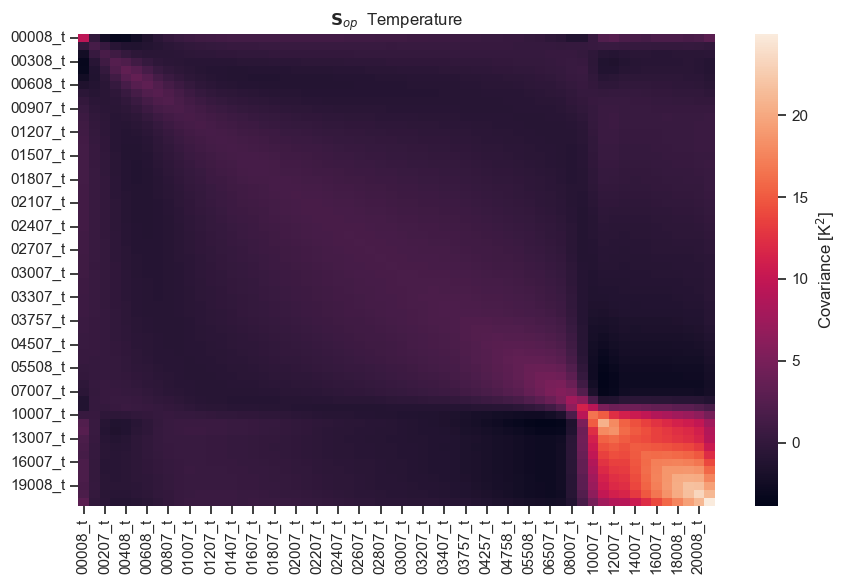

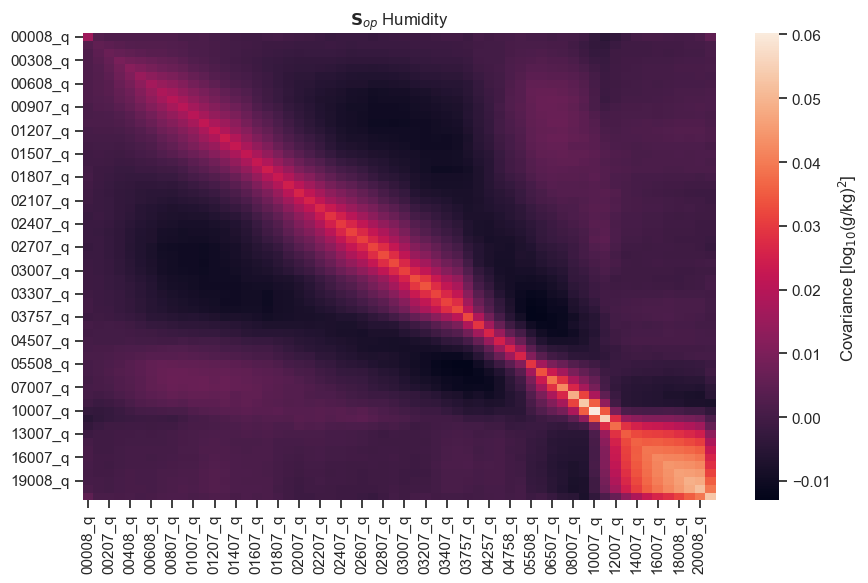

In [73]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(oe_ref.S_op .iloc[1::2, 1::2], ax=ax, cbar_kws={'label':'Covariance [K$^2$]'})
ax.set_title('$\mathbf{S}_{op}$  Temperature')

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(oe_ref.S_op .iloc[::2, ::2], ax=ax, cbar_kws={'label':'Covariance [log$_{10}$(g/kg)$^2$]'})
ax.set_title('$\mathbf{S}_{op}$ Humidity')

The square of the diagonal of are the uncertainties of the optimal solution (1 $\sigma$ range) which can be also found in 

In [74]:
oe_ref.x_op_err

00008_q    0.124836
00008_t    3.077991
00107_q    0.071329
00107_t    1.230013
00207_q    0.081954
             ...   
19008_t    4.659842
20008_q    0.227658
20008_t    4.825680
22508_q    0.230522
22508_t    4.996268
Length: 120, dtype: float64

Using a specific helper routine from `lib/supporting_routines.py` , we plot the prior and the result as vertical profiles of temperature and humidity.

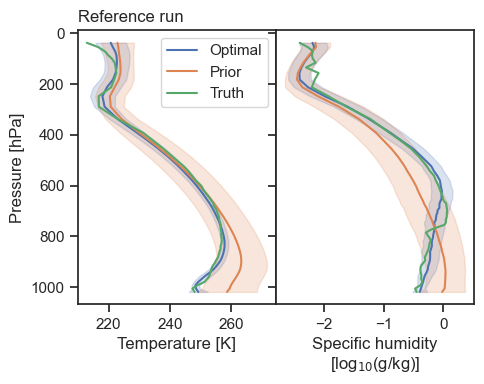

In [75]:
fig = supporting_routines.plotMwrResults(
    oe_ref,
    h=pressure.loc[season] / 100,
    hlabel='Pressure [hPa]',
    title='Reference run')

### Root mean square error
`supporting_routines` also contains a helper routine to split $\mathbf{x}$ into temperature and humidity. This allows us to e.g. estimate the root mean square errors (RMS) for $\mathbf{x}$ (and $\mathbf{y}$)

In [76]:
T_optimal, Q_optimal = supporting_routines.splitTQ(oe_ref.x_op)
T_truth, Q_truth = supporting_routines.splitTQ(oe_ref.x_truth)

print('RMS X Temperature: %g [K]'% np.sqrt(np.mean((T_optimal - T_truth)**2)))
print('RMS X Humidity: %g [log$_{10}$(g/kg)]'% np.sqrt(np.mean((10**Q_optimal - 10**Q_truth)**2)))
print('RMS Y %g [K]'% np.sqrt(np.mean((oe_ref.y_obs - oe_ref.y_op)**2)))

RMS X Temperature: 1.79078 [K]
RMS X Humidity: 0.153607 [log$_{10}$(g/kg)]
RMS Y 0.0424138 [K]


Note that we can only estimate the RMS for $\mathbf{x}$, because we used synthetic observations and know $\mathbf{x}_{truth}$

- - -

## ANN vs Optimal Estimation

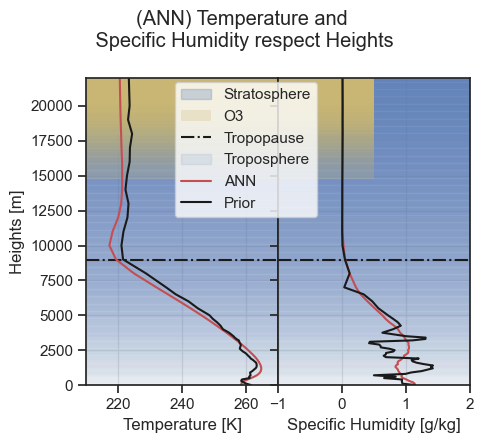

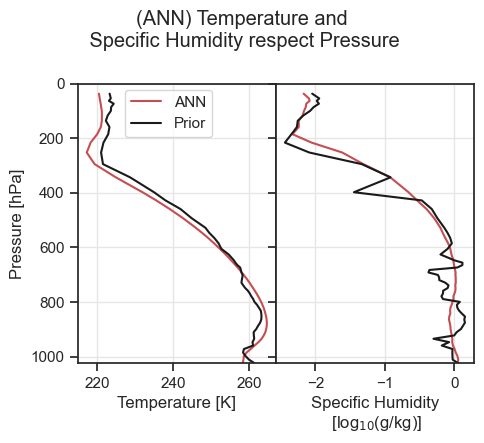

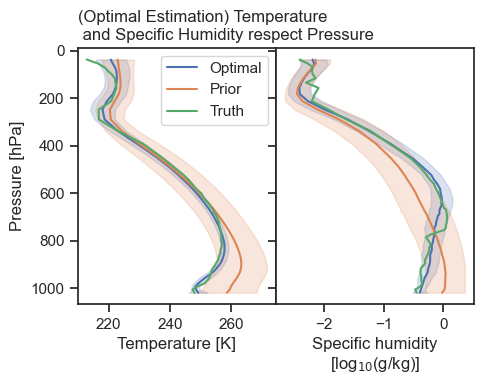

In [93]:
# ########### ANN Results ###########
tropopause = 9000 # At 9 km at the poles, 17 km at the equator. Not an “hard” barrier, not so easy to define!
walk = 25
plt.rcParams["figure.figsize"] = [5.00, 4.50]
plt.rcParams["figure.autolayout"] = True

# ################## plot respect height ##################

fig = plt.figure()
gs = fig.add_gridspec(1, 2, hspace=0, wspace=0)
(ax1, ax2) = gs.subplots(sharex='col', sharey='row')
fig.suptitle('(ANN) Temperature and\n Specific Humidity respect Heights')

# SUBPLOT TEMPERATURE
# Stratosphere
ax1.axhspan(tropopause, 23000, color="b", facecolor='0.8', alpha=0.2)
for j in range(tropopause, 23000, walk):
    ax1.axhspan(0+j, walk+j, color="b", facecolor='0.8', alpha=((j+1)/(4*23000)))
# O3    
ax1.axvspan(210, 270, 0.67, 1, facecolor='y', alpha=0.25, lw=0)
for k in np.arange(0, 1, 0.01):
    ax1.axvspan(210, 270, 0.67+k, 1+k, facecolor='y', alpha=k, lw=0)
# Tropopause
ax1.axhline(y=tropopause, color='k', linestyle='-.')
# Troposphere
ax1.axhspan(0, tropopause, color='b',facecolor='0.9', alpha=0.1)
for i in range(0, tropopause, walk):
    ax1.axhspan(0+i, walk+i, color='b',facecolor='0.9', alpha=i/(8*tropopause))
# Prediction Temperature vs Stored Temperature    
ax1.plot(temp_pred_new[0], heights, color='r')
ax1.plot(temp_test[0], heights, color='k')
ax1.set_ylim(0, 22000)
ax1.set_xlim(210,270)
ax1.grid(color='0.90')
ax1.set(xlabel='Temperature [K]', ylabel='Heights [m]')

# SUBPLOT SH
# Stratosphere
ax2.axhspan(tropopause, 23000, color="b", facecolor='0.8', alpha=0.25, label="Stratosphere")
for j in range(tropopause, 23000, walk):
    ax2.axhspan(0+j, walk+j, color="b", facecolor='0.8', alpha=((j+1)/(4*23000)))
# O3    
ax2.axvspan(-1, 0.5, 0.67, 1, facecolor='y', alpha=0.25, label="O3", lw=0)
for k in np.arange(0, 1, 0.01):
    ax2.axvspan(-1, 0.5, 0.67+k, 1+k, facecolor='y', alpha=k, lw=0)
# Tropopause
ax2.axhline(y=tropopause, color='k', linestyle='-.', label="Tropopause")
# Troposphere
ax2.axhspan(0, tropopause, color='b',facecolor='0.9', alpha=0.1, label="Troposphere")
for i in range(0, tropopause, walk):
    ax2.axhspan(0+i, walk+i, color='b',facecolor='0.9', alpha=i/(8*tropopause))
# Prediction Humidity vs Stored Humidity  
ax2.plot(q_pred[0], heights, color='r', label='ANN')
ax2.plot(q_test[0], heights, color='k', label='Prior')
ax2.set_ylim(0, 22000)
ax2.set_xlim(-1,2)
ax2.grid(color='0.90')
ax2.set(xlabel='Specific Humidity [g/kg]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in fig.get_axes():
    ax.label_outer()
    
fig.legend(loc="center left",  bbox_to_anchor=[0.35, 0.67])

plt.show()

# ################## plot respect pressure ##################
# subplot of temperature and SH respect pressure
fig = plt.figure()
gs = fig.add_gridspec(1, 2, hspace=0, wspace=0)
(ax1, ax2) = gs.subplots(sharex='col', sharey='row')
fig.suptitle('(ANN) Temperature and\n Specific Humidity respect Pressure')

# SUBPLOT TEMPERATURE
# Prediction Temperature vs Stored Temperature  
ax1.plot(temp_pred_new[0], bar_test[0]/100, color='r')
ax1.plot(temp_test[0], bar_test[0]/100, color='k')
ax1.grid(color='0.90')
ax1.set(xlabel='Temperature [K]', ylabel='Pressure [hPa]')

# SUBPLOT SH
# Prediction Humidity vs Stored Humidity 
ax2.plot(np.log10(q_pred[0]), bar_test[0]/100, color='r', label='ANN')
ax2.plot(np.log10(q_test[0]), bar_test[0]/100, color='k', label='Prior')
ax2.grid(color='0.90')
# ax2.set(xlabel='Specific Humidity\n [log10(g/kg)]')
ax2.set_xlabel('Specific Humidity\n [log$_{10}$(g/kg)]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in fig.get_axes():
    ax.label_outer()
    
fig.legend(loc="center left",  bbox_to_anchor=[0.25, 0.75])

# plt.ylim(max(bar_test[0]), min(bar_test[0]))
plt.ylim(max(bar_test[0]/100), 0) # used to invert the y-axis label order

plt.show()

# ########### Optimal Estimation results ###########
fig = supporting_routines.plotMwrResults(
    oe_ref,
    h=pressure.loc[season] / 100,
    hlabel='Pressure [hPa]',
    title='(Optimal Estimation) Temperature\n and Specific Humidity respect Pressure')


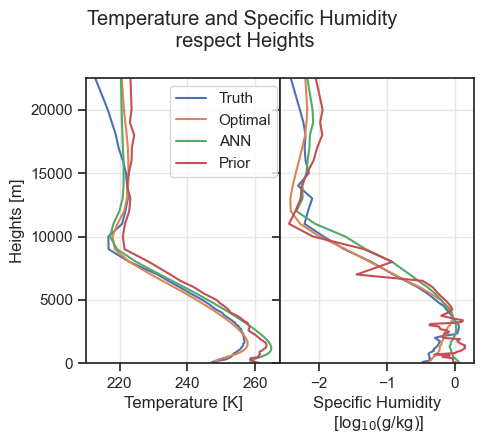

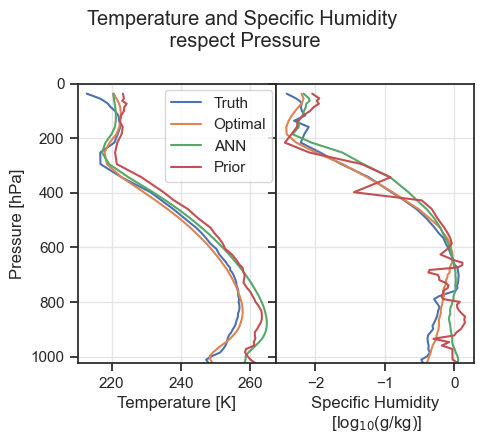

In [94]:
# Extrapolation of estimates from Optimal Estimation algorithm
t_opt, q_opt = supporting_routines.splitTQ(oe_ref.x_op)
t_op_err, q_op_err = supporting_routines.splitTQ(oe_ref.x_op_err)
t_a, q_a = supporting_routines.splitTQ(oe_ref.x_a)
t_a_err, q_a_err = supporting_routines.splitTQ(oe_ref.x_a_err)
t_truth, q_truth = supporting_routines.splitTQ(oe_ref.x_truth)

# ################## plot respect height ##################

fig = plt.figure()
gs = fig.add_gridspec(1, 2, hspace=0, wspace=0)
(ax1, ax2) = gs.subplots(sharex='col', sharey='row')
fig.suptitle('Temperature and Specific Humidity\n respect Heights')

# SUBPLOT TEMPERATURE
# Prediction Temperature vs Stored Temperature    
ax1.plot(t_truth, heights)
ax1.plot(t_opt, heights)
ax1.plot(temp_pred_new[0], heights)
ax1.plot(temp_test[0], heights)
ax1.set_ylim(0, max(heights))
# ax1.set_xlim(220,270)
ax1.grid(color='0.90')
ax1.set(xlabel='Temperature [K]', ylabel='Heights [m]')

# SUBPLOT SH
# Prediction Humidity vs Stored Humidity  
ax2.plot(q_truth, heights, label="Truth")
ax2.plot(q_opt, heights, label="Optimal")
ax2.plot(np.log10(q_pred[0]), heights, label="ANN")
ax2.plot(np.log10(q_test[0]), heights, label="Prior")
# ax2.set_ylim(0, 22000)
# ax2.set_xlim(-1,2)
ax2.grid(color='0.90')
ax2.set_xlabel('Specific Humidity\n [log$_{10}$(g/kg)]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in fig.get_axes():
    ax.label_outer()
    
fig.legend(loc="center left",  bbox_to_anchor=[0.34, 0.71])

plt.show()

# ################## plot respect pressure ##################
# subplot of temperature and SH respect pressure
fig = plt.figure()
gs = fig.add_gridspec(1, 2, hspace=0, wspace=0)
(ax1, ax2) = gs.subplots(sharex='col', sharey='row')
fig.suptitle('Temperature and Specific Humidity\n respect Pressure')

# SUBPLOT TEMPERATURE
# Prediction Temperature vs Stored Temperature  
ax1.plot(t_truth, bar_test[0]/100)
ax1.plot(t_opt, bar_test[0]/100)
ax1.plot(temp_pred_new[0], bar_test[0]/100)
ax1.plot(temp_test[0], bar_test[0]/100)
ax1.grid(color='0.90')
ax1.set(xlabel='Temperature [K]', ylabel='Pressure [hPa]')

# SUBPLOT SH
# Prediction Humidity vs Stored Humidity 
ax2.plot(q_truth, bar_test[0]/100, label="Truth")
ax2.plot(q_opt, bar_test[0]/100, label="Optimal")
ax2.plot(np.log10(q_pred[0]), bar_test[0]/100, label="ANN")
ax2.plot(np.log10(q_test[0]), bar_test[0]/100, label="Prior")
ax2.grid(color='0.90')
# ax2.set(xlabel='Specific Humidity\n [log10(g/kg)]')
ax2.set_xlabel('Specific Humidity\n [log$_{10}$(g/kg)]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in fig.get_axes():
    ax.label_outer()
    
fig.legend(loc="center left",  bbox_to_anchor=[0.33, 0.7])

# plt.ylim(max(bar_test[0]), min(bar_test[0]))
plt.ylim(max(bar_test[0]/100), 0) # used to invert the y-axis label order

plt.show()


In the last two subplots it can be seen the overall different trends and understand who is better between ANN results and Optimal Estimation results. 
How it can be seen, the plotted trend are:
- **Truth**: the real trend of temperature and specific humidity respect heights and pressures;
- **Optimal**: the trend of estimated temperature and estimated specific humidity through the Optimal Estimation algorithm;
- **ANN**: the trend of estimated temperature and estimated specific humidity through the Artificial Neural Network (ANN);
- **Prior**: the trend of temperature and specific humidity that are stored inside Prior dataset.

In conclusion, the better estimation is performed quite well by Optimal Estimation algorithm. As it's mentioned before, during the *Model Evaluation step*, the important advantage of the artificial neural network, if well constructed, is that it's generalizable. This peculiarity is not achievable in optimal estimation case because it is an algorithm built specifically for that estimation.

---

# References

Fawwaz T. Ulaby, David G. Long, William Blackwell, Charles Elachi, Adrian Fung, Chris Ruf, Kamal Sarabandi, Howard Zebker, Jakob van Zyl, 2014: Microwave Radar and Radiometric Remote Sensing. *The University of Michigan Press Manufactured in the United States of America*, 1-1013, ISBN 978-0-472-11935-6.

Iain H. Woodhouse, 2006: Introduction to Microwave Remote Sensing. *CRC Press Taylor & Francis Group*, 1-397.

Casella Daniele [2023], *Microwaves* course slides.